In [53]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [56]:
test_df.loc[test_df['answerCode'] != -1]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244


In [23]:
import pandas as pd
import datetime as dt
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

def extract_datetime(df):
    df['month'] = pd.to_datetime(df['Timestamp']).apply(lambda x : x.month)
    df['day'] = pd.to_datetime(df['Timestamp']).apply(lambda x : x.day)
    df['hour'] = pd.to_datetime(df['Timestamp']).apply(lambda x : x.hour)
    df['minute'] = pd.to_datetime(df['Timestamp']).apply(lambda x : x.minute)
    df['second'] = pd.to_datetime(df['Timestamp']).apply(lambda x : x.second)
    df.drop(['Timestamp'], axis=1, inplace=True)
    return df

def extract_testId(df):
    df['testClass'] = df['testId'].apply(lambda x : int(x[2]))
    df['testCode'] = df['testId'].apply(lambda x : int(x[7:]))
    df.drop(['testId'], axis=1, inplace=True)
    return df

def extract_assessmentItemID(df):
    df['assessmentItemCode'] = df['assessmentItemID'].apply(lambda x : int(x[7:]))
    df.drop(['assessmentItemID'], axis=1, inplace=True)
    return df

train_df = extract_datetime(train_df)
test_df = extract_datetime(test_df)
train_df = extract_testId(train_df)
test_df = extract_testId(test_df)
train_df = extract_assessmentItemID(train_df)
test_df = extract_assessmentItemID(test_df)

cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

train_df

,userID,answerCode,KnowledgeTag,month,day,hour,minute,second,testClass,testCode,assessmentItemCode
0,0,1,7224,3,24,0,17,11,6,1,1
1,0,1,7225,3,24,0,17,14,6,1,2
2,0,1,7225,3,24,0,17,22,6,1,3
3,0,1,7225,3,24,0,17,29,6,1,4
4,0,1,7225,3,24,0,17,36,6,1,5
...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,0,438,6,5,6,50,21,3,71,5
2266582,7441,1,8836,8,21,1,6,39,4,165,1
2266583,7441,1,8836,8,21,1,6,50,4,165,2
2266584,7441,1,8836,8,21,1,7,36,4,165,3


In [18]:
import pandas as pd
import numpy as np
import datetime as dt
import lightgbm as lgb
import optuna

from optuna.samplers import TPESampler
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.set_option('mode.chained_assignment',  None)
sampler = TPESampler(seed=777)

train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

def extract_datetime(df):
    df['month'] = pd.to_datetime(df['Timestamp']).apply(lambda x : x.month)
    df['day'] = pd.to_datetime(df['Timestamp']).apply(lambda x : x.day)
    df['hour'] = pd.to_datetime(df['Timestamp']).apply(lambda x : x.hour)
    df['minute'] = pd.to_datetime(df['Timestamp']).apply(lambda x : x.minute)
    df['second'] = pd.to_datetime(df['Timestamp']).apply(lambda x : x.second)
    df.drop(['Timestamp'], axis=1, inplace=True)
    return df

def extract_testId(df):
    df['testClass'] = df['testId'].apply(lambda x : int(x[2]))
    df['testCode'] = df['testId'].apply(lambda x : int(x[7:]))
    df.drop(['testId'], axis=1, inplace=True)
    return df

def extract_assessmentItemID(df):
    df['assessmentItemCode'] = df['assessmentItemID'].apply(lambda x : int(x[7:]))
    df.drop(['assessmentItemID'], axis=1, inplace=True)
    return df

# train_df = extract_datetime(train_df)
# test_df = extract_datetime(test_df)
# train_df = extract_testId(train_df)
# test_df = extract_testId(test_df)
# train_df = extract_assessmentItemID(train_df)
# test_df = extract_assessmentItemID(test_df)

# train_X = train_df.drop(['answerCode'], axis=1)
# train_y = train_df['answerCode']

total = pd.concat([train_df, test_df.loc[test_df['answerCode'] != -1] ], axis=0)
total = extract_datetime(total)
total = extract_testId(total)
total = extract_assessmentItemID(total)
train_X = total.drop(['answerCode'], axis=1)
train_y = total['answerCode']

h_train_X, h_valid_X, h_train_y, h_valid_y = train_test_split(train_X, train_y, test_size=0.3, stratify=train_y, random_state=777)

print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(1768169, 10) (1768169,) (757787, 10) (757787,)


In [69]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.4, 1.0),
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "random_state" : 777,
        "learning_rate" : trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        "task_type" : "GPU",
    }

    if param["bootstrap_type"] == "Bayesian":
        # param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.01, 100.00)

    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat = CatBoostClassifier(**param, cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], )

    cat.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)

    preds = cat.predict(h_valid_X)
    pred_labels = np.rint(preds)
    accuracy = roc_auc_score(h_valid_y, pred_labels)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [71]:
trial = study.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.6403067271762217,
params {'objective': 'CrossEntropy', 'colsample_bylevel': 0.6268192529849563, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'learning_rate': 0.059400962111501, 'n_estimators': 4281, 'l2_leaf_reg': 5.167798448510917e-07, 'min_child_samples': 40, 'max_bin': 435, 'bagging_temperature': 6.985703797600216}


In [ ]:
# Best Trial: score 0.6403067271762217,
# params {'objective': 'CrossEntropy', 'colsample_bylevel': 0.6268192529849563, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'learning_rate': 0.059400962111501, 'n_estimators': 4281, 'l2_leaf_reg': 5.167798448510917e-07, 'min_child_samples': 40, 'max_bin': 435, 'bagging_temperature': 6.985703797600216}

In [19]:
def objective(trial):
    param = {
        # 'objective': 'binary', # 이진 분류
        "objective": trial.suggest_categorical("objective", ["binary", "cross_entropy"]),
        # "tree_learner": trial.suggest_categorical("tree_learner", ["serial", "feature", "data", "voting"]),
        'verbose': -1,
        'metric': 'AUC',
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 0.001, 0.03),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        # 'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        'lambda_l1' : trial.suggest_loguniform('lambda_l1', 1e-8, 1e-1),
        'lambda_l2' : trial.suggest_loguniform('lambda_l2', 1e-8, 1e-1),
        'path_smooth' : trial.suggest_loguniform('path_smooth', 1e-8, 1e-3),
        'num_leaves' : trial.suggest_int('num_leaves', 30, 200),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 10, 100),
        'max_bin' : trial.suggest_int('max_bin', 100, 255),
        'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.5, 0.9),
        'bagging_fraction' : trial.suggest_uniform('bagging_fraction', 0.5, 0.9),
        # 'device' : 'gpu',
        # 'reg_alpha' : None,
    }

    model = lgb.LGBMClassifier(**param, categorical_feature=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    loss = roc_auc_score(h_valid_y, lgb_model.predict(h_valid_X))
    return loss
        
study_lgb = optuna.create_study(direction='maximize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-11-16 13:56:09,887] A new study created in memory with name: no-name-a25cefe4-4bcb-48c2-8ac2-aece943f263c
[I 2022-11-16 13:56:13,132] Trial 0 finished with value: 0.5 and parameters: {'objective': 'cross_entropy', 'max_depth': 3, 'learning_rate': 0.004778256780953745, 'n_estimators': 4193, 'min_child_samples': 93, 'lambda_l1': 0.0012272213164610333, 'lambda_l2': 0.0023959268442731276, 'path_smooth': 2.2183258107863225e-07, 'num_leaves': 140, 'min_data_in_leaf': 18, 'max_bin': 112, 'feature_fraction': 0.7358455013823457, 'bagging_fraction': 0.6373362152887747}. Best is trial 0 with value: 0.5.


[LightGBM] [Warning] lambda_l1 is set=3.6349353663794747e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6349353663794747e-07
[LightGBM] [Warning] bagging_fraction is set=0.6012475776818278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6012475776818278
[LightGBM] [Warning] lambda_l2 is set=2.0188228074917628e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0188228074917628e-07
[LightGBM] [Warning] feature_fraction is set=0.7489355297282327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7489355297282327
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=65


[I 2022-11-16 13:59:35,203] Trial 1 finished with value: 0.6693732782714851 and parameters: {'objective': 'binary', 'max_depth': 11, 'learning_rate': 0.006542598618892924, 'n_estimators': 1417, 'min_child_samples': 40, 'lambda_l1': 3.6349353663794747e-07, 'lambda_l2': 2.0188228074917628e-07, 'path_smooth': 8.979258351381595e-07, 'num_leaves': 63, 'min_data_in_leaf': 65, 'max_bin': 237, 'feature_fraction': 0.7489355297282327, 'bagging_fraction': 0.6012475776818278}. Best is trial 1 with value: 0.6693732782714851.


[LightGBM] [Warning] lambda_l1 is set=5.349871853721841e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.349871853721841e-05
[LightGBM] [Warning] bagging_fraction is set=0.7448094317092934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7448094317092934
[LightGBM] [Warning] lambda_l2 is set=1.2392825868578523e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2392825868578523e-08
[LightGBM] [Warning] feature_fraction is set=0.6183490776349688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6183490776349688
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=80


[I 2022-11-16 14:03:26,350] Trial 2 finished with value: 0.6462771179777139 and parameters: {'objective': 'cross_entropy', 'max_depth': 5, 'learning_rate': 0.005800436372006536, 'n_estimators': 2641, 'min_child_samples': 62, 'lambda_l1': 5.349871853721841e-05, 'lambda_l2': 1.2392825868578523e-08, 'path_smooth': 4.173364449604953e-06, 'num_leaves': 183, 'min_data_in_leaf': 80, 'max_bin': 119, 'feature_fraction': 0.6183490776349688, 'bagging_fraction': 0.7448094317092934}. Best is trial 1 with value: 0.6693732782714851.


[LightGBM] [Warning] lambda_l1 is set=2.021056433295407e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.021056433295407e-05
[LightGBM] [Warning] bagging_fraction is set=0.5107769041950028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5107769041950028
[LightGBM] [Warning] lambda_l2 is set=0.003492968944465814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003492968944465814
[LightGBM] [Warning] feature_fraction is set=0.6798074999663026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6798074999663026
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=42


[I 2022-11-16 14:03:34,442] Trial 3 finished with value: 0.5 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.0019189438584232305, 'n_estimators': 2834, 'min_child_samples': 57, 'lambda_l1': 2.021056433295407e-05, 'lambda_l2': 0.003492968944465814, 'path_smooth': 3.769193132689633e-08, 'num_leaves': 146, 'min_data_in_leaf': 42, 'max_bin': 153, 'feature_fraction': 0.6798074999663026, 'bagging_fraction': 0.5107769041950028}. Best is trial 1 with value: 0.6693732782714851.


[LightGBM] [Warning] lambda_l1 is set=1.3880618171916978e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3880618171916978e-05
[LightGBM] [Warning] bagging_fraction is set=0.7187164843565222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7187164843565222
[LightGBM] [Warning] lambda_l2 is set=1.3011905677957856e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3011905677957856e-08
[LightGBM] [Warning] feature_fraction is set=0.8395097215390547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8395097215390547
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=86


[I 2022-11-16 14:07:08,995] Trial 4 finished with value: 0.6243100869979911 and parameters: {'objective': 'cross_entropy', 'max_depth': 4, 'learning_rate': 0.0029206067116600704, 'n_estimators': 2687, 'min_child_samples': 36, 'lambda_l1': 1.3880618171916978e-05, 'lambda_l2': 1.3011905677957856e-08, 'path_smooth': 3.0558674531010326e-08, 'num_leaves': 148, 'min_data_in_leaf': 86, 'max_bin': 166, 'feature_fraction': 0.8395097215390547, 'bagging_fraction': 0.7187164843565222}. Best is trial 1 with value: 0.6693732782714851.


[LightGBM] [Warning] lambda_l1 is set=1.1965834302140958e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1965834302140958e-06
[LightGBM] [Warning] bagging_fraction is set=0.6599109264908691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6599109264908691
[LightGBM] [Warning] lambda_l2 is set=1.2928199046994122e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2928199046994122e-06
[LightGBM] [Warning] feature_fraction is set=0.5117794317165487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5117794317165487
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=67


[I 2022-11-16 14:10:07,086] Trial 5 finished with value: 0.6536875555981725 and parameters: {'objective': 'cross_entropy', 'max_depth': 4, 'learning_rate': 0.020838224134181113, 'n_estimators': 1748, 'min_child_samples': 90, 'lambda_l1': 1.1965834302140958e-06, 'lambda_l2': 1.2928199046994122e-06, 'path_smooth': 0.00010744916431686771, 'num_leaves': 173, 'min_data_in_leaf': 67, 'max_bin': 148, 'feature_fraction': 0.5117794317165487, 'bagging_fraction': 0.6599109264908691}. Best is trial 1 with value: 0.6693732782714851.


[LightGBM] [Warning] lambda_l1 is set=1.932509763731631e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.932509763731631e-06
[LightGBM] [Warning] bagging_fraction is set=0.5810067212290936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5810067212290936
[LightGBM] [Warning] lambda_l2 is set=0.022177719676913843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.022177719676913843
[LightGBM] [Warning] feature_fraction is set=0.8900849833714146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8900849833714146
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=13


[I 2022-11-16 14:12:26,013] Trial 6 finished with value: 0.6980892456944943 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.018287635818813493, 'n_estimators': 744, 'min_child_samples': 32, 'lambda_l1': 1.932509763731631e-06, 'lambda_l2': 0.022177719676913843, 'path_smooth': 0.0009949418900135276, 'num_leaves': 161, 'min_data_in_leaf': 13, 'max_bin': 250, 'feature_fraction': 0.8900849833714146, 'bagging_fraction': 0.5810067212290936}. Best is trial 6 with value: 0.6980892456944943.


[LightGBM] [Warning] lambda_l1 is set=0.00087482602688196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00087482602688196
[LightGBM] [Warning] bagging_fraction is set=0.712837180422895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712837180422895
[LightGBM] [Warning] lambda_l2 is set=0.0026386397996848356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026386397996848356
[LightGBM] [Warning] feature_fraction is set=0.647150360092577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.647150360092577
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=25


[I 2022-11-16 14:16:48,226] Trial 7 finished with value: 0.6885593872138197 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.011902838692685967, 'n_estimators': 1304, 'min_child_samples': 6, 'lambda_l1': 0.00087482602688196, 'lambda_l2': 0.0026386397996848356, 'path_smooth': 2.316717147746947e-06, 'num_leaves': 167, 'min_data_in_leaf': 25, 'max_bin': 212, 'feature_fraction': 0.647150360092577, 'bagging_fraction': 0.712837180422895}. Best is trial 6 with value: 0.6980892456944943.


[LightGBM] [Warning] lambda_l1 is set=4.505547970482377e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505547970482377e-05
[LightGBM] [Warning] bagging_fraction is set=0.8081208008262204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8081208008262204
[LightGBM] [Warning] lambda_l2 is set=5.521887031259565e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.521887031259565e-08
[LightGBM] [Warning] feature_fraction is set=0.5067569163275346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5067569163275346
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=65


[I 2022-11-16 14:17:04,630] Trial 8 finished with value: 0.5 and parameters: {'objective': 'cross_entropy', 'max_depth': 12, 'learning_rate': 0.003878326859428971, 'n_estimators': 618, 'min_child_samples': 43, 'lambda_l1': 4.505547970482377e-05, 'lambda_l2': 5.521887031259565e-08, 'path_smooth': 0.0001851236657325161, 'num_leaves': 118, 'min_data_in_leaf': 65, 'max_bin': 229, 'feature_fraction': 0.5067569163275346, 'bagging_fraction': 0.8081208008262204}. Best is trial 6 with value: 0.6980892456944943.


[LightGBM] [Warning] lambda_l1 is set=0.004499437469607811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004499437469607811
[LightGBM] [Warning] bagging_fraction is set=0.7681060138388102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7681060138388102
[LightGBM] [Warning] lambda_l2 is set=5.175130824700228e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.175130824700228e-08
[LightGBM] [Warning] feature_fraction is set=0.7544202416604087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7544202416604087
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=86


[I 2022-11-16 14:18:00,189] Trial 9 finished with value: 0.6368311585276891 and parameters: {'objective': 'binary', 'max_depth': 4, 'learning_rate': 0.020502952318234256, 'n_estimators': 622, 'min_child_samples': 28, 'lambda_l1': 0.004499437469607811, 'lambda_l2': 5.175130824700228e-08, 'path_smooth': 2.462786506980637e-08, 'num_leaves': 89, 'min_data_in_leaf': 86, 'max_bin': 110, 'feature_fraction': 0.7544202416604087, 'bagging_fraction': 0.7681060138388102}. Best is trial 6 with value: 0.6980892456944943.


[LightGBM] [Warning] lambda_l1 is set=1.2228348167024952e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2228348167024952e-08
[LightGBM] [Warning] bagging_fraction is set=0.8966121947838954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8966121947838954
[LightGBM] [Warning] lambda_l2 is set=6.536466386015257e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.536466386015257e-05
[LightGBM] [Warning] feature_fraction is set=0.8624052561594474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8624052561594474
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=40


[I 2022-11-16 14:18:08,155] Trial 10 finished with value: 0.5 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.0010641838942246446, 'n_estimators': 113, 'min_child_samples': 13, 'lambda_l1': 1.2228348167024952e-08, 'lambda_l2': 6.536466386015257e-05, 'path_smooth': 0.0008056374010815713, 'num_leaves': 40, 'min_data_in_leaf': 40, 'max_bin': 198, 'feature_fraction': 0.8624052561594474, 'bagging_fraction': 0.8966121947838954}. Best is trial 6 with value: 0.6980892456944943.


[LightGBM] [Warning] lambda_l1 is set=0.01981293882216289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01981293882216289
[LightGBM] [Warning] bagging_fraction is set=0.5394983949530401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5394983949530401
[LightGBM] [Warning] lambda_l2 is set=0.05434875151786701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05434875151786701
[LightGBM] [Warning] feature_fraction is set=0.6142844611019586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6142844611019586
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=12


[I 2022-11-16 14:23:43,070] Trial 11 finished with value: 0.695475544552308 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.01199724368158202, 'n_estimators': 1556, 'min_child_samples': 6, 'lambda_l1': 0.01981293882216289, 'lambda_l2': 0.05434875151786701, 'path_smooth': 1.1534224501642687e-05, 'num_leaves': 200, 'min_data_in_leaf': 12, 'max_bin': 207, 'feature_fraction': 0.6142844611019586, 'bagging_fraction': 0.5394983949530401}. Best is trial 6 with value: 0.6980892456944943.


[LightGBM] [Warning] lambda_l1 is set=0.08293629827273667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08293629827273667
[LightGBM] [Warning] bagging_fraction is set=0.5249960592718025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249960592718025
[LightGBM] [Warning] lambda_l2 is set=0.08588260259966511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08588260259966511
[LightGBM] [Warning] feature_fraction is set=0.5842068937168314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5842068937168314
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=11


[I 2022-11-16 14:30:05,283] Trial 12 finished with value: 0.6745402335516638 and parameters: {'objective': 'binary', 'max_depth': 8, 'learning_rate': 0.011368881474809814, 'n_estimators': 1784, 'min_child_samples': 19, 'lambda_l1': 0.08293629827273667, 'lambda_l2': 0.08588260259966511, 'path_smooth': 1.8781164681234807e-05, 'num_leaves': 196, 'min_data_in_leaf': 11, 'max_bin': 250, 'feature_fraction': 0.5842068937168314, 'bagging_fraction': 0.5249960592718025}. Best is trial 6 with value: 0.6980892456944943.


[LightGBM] [Warning] lambda_l1 is set=6.408033339258746e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.408033339258746e-07
[LightGBM] [Warning] bagging_fraction is set=0.5640445847623466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5640445847623466
[LightGBM] [Warning] lambda_l2 is set=0.019136056844411962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019136056844411962
[LightGBM] [Warning] feature_fraction is set=0.8025073285551773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8025073285551773
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=30


[I 2022-11-16 15:02:17,101] Trial 13 finished with value: 0.7396432480581144 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.029684618457012073, 'n_estimators': 3621, 'min_child_samples': 25, 'lambda_l1': 6.408033339258746e-07, 'lambda_l2': 0.019136056844411962, 'path_smooth': 2.741155245258482e-05, 'num_leaves': 193, 'min_data_in_leaf': 30, 'max_bin': 195, 'feature_fraction': 0.8025073285551773, 'bagging_fraction': 0.5640445847623466}. Best is trial 13 with value: 0.7396432480581144.


[LightGBM] [Warning] lambda_l1 is set=7.009980977670675e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.009980977670675e-08
[LightGBM] [Warning] bagging_fraction is set=0.586097343623719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.586097343623719
[LightGBM] [Warning] lambda_l2 is set=0.00023442841506904244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023442841506904244
[LightGBM] [Warning] feature_fraction is set=0.8988184348840025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8988184348840025
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=33


[I 2022-11-16 15:10:07,649] Trial 14 finished with value: 0.7362933993586609 and parameters: {'objective': 'binary', 'max_depth': 9, 'learning_rate': 0.028176650363000266, 'n_estimators': 3881, 'min_child_samples': 70, 'lambda_l1': 7.009980977670675e-08, 'lambda_l2': 0.00023442841506904244, 'path_smooth': 0.000782910847520918, 'num_leaves': 117, 'min_data_in_leaf': 33, 'max_bin': 181, 'feature_fraction': 0.8988184348840025, 'bagging_fraction': 0.586097343623719}. Best is trial 13 with value: 0.7396432480581144.


[LightGBM] [Warning] lambda_l1 is set=3.3840025333969344e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3840025333969344e-08
[LightGBM] [Warning] bagging_fraction is set=0.5797323630171572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797323630171572
[LightGBM] [Warning] lambda_l2 is set=5.75465452262777e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.75465452262777e-05
[LightGBM] [Warning] feature_fraction is set=0.8158220896555428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8158220896555428
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=34


[I 2022-11-16 15:18:07,078] Trial 15 finished with value: 0.7357184556923693 and parameters: {'objective': 'binary', 'max_depth': 9, 'learning_rate': 0.02933616529647329, 'n_estimators': 4128, 'min_child_samples': 75, 'lambda_l1': 3.3840025333969344e-08, 'lambda_l2': 5.75465452262777e-05, 'path_smooth': 8.153612434283846e-05, 'num_leaves': 106, 'min_data_in_leaf': 34, 'max_bin': 175, 'feature_fraction': 0.8158220896555428, 'bagging_fraction': 0.5797323630171572}. Best is trial 13 with value: 0.7396432480581144.


[LightGBM] [Warning] lambda_l1 is set=7.851596660226321e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.851596660226321e-08
[LightGBM] [Warning] bagging_fraction is set=0.6483239920009878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6483239920009878
[LightGBM] [Warning] lambda_l2 is set=0.00034828681398093084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00034828681398093084
[LightGBM] [Warning] feature_fraction is set=0.8025413542059588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8025413542059588
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=45


[I 2022-11-16 15:27:20,168] Trial 16 finished with value: 0.7320156736195197 and parameters: {'objective': 'binary', 'max_depth': 7, 'learning_rate': 0.02982927497190712, 'n_estimators': 4899, 'min_child_samples': 76, 'lambda_l1': 7.851596660226321e-08, 'lambda_l2': 0.00034828681398093084, 'path_smooth': 3.264929413124566e-05, 'num_leaves': 79, 'min_data_in_leaf': 45, 'max_bin': 192, 'feature_fraction': 0.8025413542059588, 'bagging_fraction': 0.6483239920009878}. Best is trial 13 with value: 0.7396432480581144.


[LightGBM] [Warning] lambda_l1 is set=1.9647153264419493e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9647153264419493e-07
[LightGBM] [Warning] bagging_fraction is set=0.5580068871371826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5580068871371826
[LightGBM] [Warning] lambda_l2 is set=6.187414175569679e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.187414175569679e-06
[LightGBM] [Warning] feature_fraction is set=0.8950687344034021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8950687344034021
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=29


[I 2022-11-16 15:36:20,347] Trial 17 finished with value: 0.7102111857648561 and parameters: {'objective': 'binary', 'max_depth': 10, 'learning_rate': 0.009431094209887332, 'n_estimators': 3418, 'min_child_samples': 67, 'lambda_l1': 1.9647153264419493e-07, 'lambda_l2': 6.187414175569679e-06, 'path_smooth': 0.00024015251978084961, 'num_leaves': 122, 'min_data_in_leaf': 29, 'max_bin': 182, 'feature_fraction': 0.8950687344034021, 'bagging_fraction': 0.5580068871371826}. Best is trial 13 with value: 0.7396432480581144.


[LightGBM] [Warning] lambda_l1 is set=2.971773135261932e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.971773135261932e-06
[LightGBM] [Warning] bagging_fraction is set=0.6162534956567404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6162534956567404
[LightGBM] [Warning] lambda_l2 is set=0.0003268449657040694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003268449657040694
[LightGBM] [Warning] feature_fraction is set=0.7917882204057054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7917882204057054
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=57


[I 2022-11-16 15:42:40,570] Trial 18 finished with value: 0.7002883792334539 and parameters: {'objective': 'binary', 'max_depth': 7, 'learning_rate': 0.016567902673797888, 'n_estimators': 3476, 'min_child_samples': 50, 'lambda_l1': 2.971773135261932e-06, 'lambda_l2': 0.0003268449657040694, 'path_smooth': 4.862627937003171e-07, 'num_leaves': 36, 'min_data_in_leaf': 57, 'max_bin': 139, 'feature_fraction': 0.7917882204057054, 'bagging_fraction': 0.6162534956567404}. Best is trial 13 with value: 0.7396432480581144.


[LightGBM] [Warning] lambda_l1 is set=1.3192374682408013e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3192374682408013e-08
[LightGBM] [Warning] bagging_fraction is set=0.6537748529577965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6537748529577965
[LightGBM] [Warning] lambda_l2 is set=0.008383848413550325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008383848413550325
[LightGBM] [Warning] feature_fraction is set=0.8408548672995557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8408548672995557
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=48


[I 2022-11-16 15:52:55,278] Trial 19 finished with value: 0.7399754815050812 and parameters: {'objective': 'binary', 'max_depth': 10, 'learning_rate': 0.029747777430609645, 'n_estimators': 4975, 'min_child_samples': 83, 'lambda_l1': 1.3192374682408013e-08, 'lambda_l2': 0.008383848413550325, 'path_smooth': 0.0003391007516553514, 'num_leaves': 101, 'min_data_in_leaf': 48, 'max_bin': 221, 'feature_fraction': 0.8408548672995557, 'bagging_fraction': 0.6537748529577965}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=1.5864267515356145e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5864267515356145e-08
[LightGBM] [Warning] bagging_fraction is set=0.6688735557749174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6688735557749174
[LightGBM] [Warning] lambda_l2 is set=0.009955428322199986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009955428322199986
[LightGBM] [Warning] feature_fraction is set=0.7115079730474021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7115079730474021
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=51


[I 2022-11-16 16:04:47,571] Trial 20 finished with value: 0.7130635491071544 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.008629323787894017, 'n_estimators': 4898, 'min_child_samples': 84, 'lambda_l1': 1.5864267515356145e-08, 'lambda_l2': 0.009955428322199986, 'path_smooth': 4.2473553218519915e-05, 'num_leaves': 98, 'min_data_in_leaf': 51, 'max_bin': 221, 'feature_fraction': 0.7115079730474021, 'bagging_fraction': 0.6688735557749174}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=1.2658075946052068e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2658075946052068e-07
[LightGBM] [Warning] bagging_fraction is set=0.6132690064211505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6132690064211505
[LightGBM] [Warning] lambda_l2 is set=0.00038269304415293964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00038269304415293964
[LightGBM] [Warning] feature_fraction is set=0.8577396458080296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8577396458080296
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=26


[I 2022-11-16 16:12:05,259] Trial 21 finished with value: 0.7362338574575102 and parameters: {'objective': 'binary', 'max_depth': 10, 'learning_rate': 0.0292841902881369, 'n_estimators': 4205, 'min_child_samples': 99, 'lambda_l1': 1.2658075946052068e-07, 'lambda_l2': 0.00038269304415293964, 'path_smooth': 0.0003999598892481335, 'num_leaves': 65, 'min_data_in_leaf': 26, 'max_bin': 193, 'feature_fraction': 0.8577396458080296, 'bagging_fraction': 0.6132690064211505}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=7.290336768529986e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.290336768529986e-07
[LightGBM] [Warning] bagging_fraction is set=0.562130689357296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.562130689357296
[LightGBM] [Warning] lambda_l2 is set=0.010585800713304228, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010585800713304228
[LightGBM] [Warning] feature_fraction is set=0.7791782005027128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7791782005027128
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=36


[I 2022-11-16 16:17:56,713] Trial 22 finished with value: 0.7079283497471365 and parameters: {'objective': 'binary', 'max_depth': 8, 'learning_rate': 0.016136023915263028, 'n_estimators': 3357, 'min_child_samples': 73, 'lambda_l1': 7.290336768529986e-07, 'lambda_l2': 0.010585800713304228, 'path_smooth': 0.00038937628659273195, 'num_leaves': 128, 'min_data_in_leaf': 36, 'max_bin': 167, 'feature_fraction': 0.7791782005027128, 'bagging_fraction': 0.562130689357296}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=6.72492675662605e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.72492675662605e-08
[LightGBM] [Warning] bagging_fraction is set=0.5001272357245926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5001272357245926
[LightGBM] [Warning] lambda_l2 is set=0.0012958012105107404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012958012105107404
[LightGBM] [Warning] feature_fraction is set=0.8340088957474638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8340088957474638
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=49


[I 2022-11-16 16:26:12,618] Trial 23 finished with value: 0.7324490289006312 and parameters: {'objective': 'binary', 'max_depth': 10, 'learning_rate': 0.02340377094954367, 'n_estimators': 4507, 'min_child_samples': 85, 'lambda_l1': 6.72492675662605e-08, 'lambda_l2': 0.0012958012105107404, 'path_smooth': 5.788607047972399e-06, 'num_leaves': 81, 'min_data_in_leaf': 49, 'max_bin': 211, 'feature_fraction': 0.8340088957474638, 'bagging_fraction': 0.5001272357245926}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=1.3729107422765082e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3729107422765082e-08
[LightGBM] [Warning] bagging_fraction is set=0.670927725953428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.670927725953428
[LightGBM] [Warning] lambda_l2 is set=9.831722882568806e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.831722882568806e-06
[LightGBM] [Warning] feature_fraction is set=0.8746963295159639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8746963295159639
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=32


[I 2022-11-16 16:32:15,199] Trial 24 finished with value: 0.7082868340669379 and parameters: {'objective': 'binary', 'max_depth': 7, 'learning_rate': 0.01514569009528317, 'n_estimators': 3655, 'min_child_samples': 51, 'lambda_l1': 1.3729107422765082e-08, 'lambda_l2': 9.831722882568806e-06, 'path_smooth': 8.428683000626298e-05, 'num_leaves': 105, 'min_data_in_leaf': 32, 'max_bin': 181, 'feature_fraction': 0.8746963295159639, 'bagging_fraction': 0.670927725953428}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=6.251641637138504e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.251641637138504e-06
[LightGBM] [Warning] bagging_fraction is set=0.5954303782338677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5954303782338677
[LightGBM] [Warning] lambda_l2 is set=0.016875512198596267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016875512198596267
[LightGBM] [Warning] feature_fraction is set=0.8218069694472335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8218069694472335
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=57


[I 2022-11-16 16:38:14,514] Trial 25 finished with value: 0.7238429713687426 and parameters: {'objective': 'binary', 'max_depth': 11, 'learning_rate': 0.02543374405833112, 'n_estimators': 3748, 'min_child_samples': 67, 'lambda_l1': 6.251641637138504e-06, 'lambda_l2': 0.016875512198596267, 'path_smooth': 0.0004706429917608373, 'num_leaves': 58, 'min_data_in_leaf': 57, 'max_bin': 232, 'feature_fraction': 0.8218069694472335, 'bagging_fraction': 0.5954303782338677}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=4.296828123257522e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.296828123257522e-07
[LightGBM] [Warning] bagging_fraction is set=0.548102035250472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.548102035250472
[LightGBM] [Warning] lambda_l2 is set=0.00015896230302036551, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015896230302036551
[LightGBM] [Warning] feature_fraction is set=0.7781179721021637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7781179721021637
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=23


[I 2022-11-16 16:41:27,232] Trial 26 finished with value: 0.678694438686603 and parameters: {'objective': 'cross_entropy', 'max_depth': 6, 'learning_rate': 0.014016997066930846, 'n_estimators': 2278, 'min_child_samples': 25, 'lambda_l1': 4.296828123257522e-07, 'lambda_l2': 0.00015896230302036551, 'path_smooth': 4.8446060556843e-05, 'num_leaves': 136, 'min_data_in_leaf': 23, 'max_bin': 202, 'feature_fraction': 0.7781179721021637, 'bagging_fraction': 0.548102035250472}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=4.7281356162999936e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7281356162999936e-08
[LightGBM] [Warning] bagging_fraction is set=0.6860985552627415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6860985552627415
[LightGBM] [Warning] lambda_l2 is set=0.0008264181827949438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008264181827949438
[LightGBM] [Warning] feature_fraction is set=0.8471013987579418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8471013987579418
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=40


[I 2022-11-16 16:47:13,917] Trial 27 finished with value: 0.7205237359496195 and parameters: {'objective': 'binary', 'max_depth': 9, 'learning_rate': 0.021619828611565854, 'n_estimators': 3052, 'min_child_samples': 81, 'lambda_l1': 4.7281356162999936e-08, 'lambda_l2': 0.0008264181827949438, 'path_smooth': 0.00016742107088953945, 'num_leaves': 155, 'min_data_in_leaf': 40, 'max_bin': 219, 'feature_fraction': 0.8471013987579418, 'bagging_fraction': 0.6860985552627415}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=1.8694454390403365e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8694454390403365e-07
[LightGBM] [Warning] bagging_fraction is set=0.6294322908897684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6294322908897684
[LightGBM] [Warning] lambda_l2 is set=0.0055812399191104475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0055812399191104475
[LightGBM] [Warning] feature_fraction is set=0.8784901314888031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8784901314888031
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=97


[I 2022-11-16 16:57:02,912] Trial 28 finished with value: 0.7389422106239117 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.023351655108788293, 'n_estimators': 4636, 'min_child_samples': 58, 'lambda_l1': 1.8694454390403365e-07, 'lambda_l2': 0.0055812399191104475, 'path_smooth': 1.6909852546301978e-05, 'num_leaves': 108, 'min_data_in_leaf': 97, 'max_bin': 189, 'feature_fraction': 0.8784901314888031, 'bagging_fraction': 0.6294322908897684}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=0.0002503496945310772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002503496945310772
[LightGBM] [Warning] bagging_fraction is set=0.6299030344196483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6299030344196483
[LightGBM] [Warning] lambda_l2 is set=0.004855590978893425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004855590978893425
[LightGBM] [Warning] feature_fraction is set=0.6969219756892309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6969219756892309
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=94


[I 2022-11-16 17:08:52,822] Trial 29 finished with value: 0.7094654390301522 and parameters: {'objective': 'cross_entropy', 'max_depth': 14, 'learning_rate': 0.0069458642825609455, 'n_estimators': 4413, 'min_child_samples': 45, 'lambda_l1': 0.0002503496945310772, 'lambda_l2': 0.004855590978893425, 'path_smooth': 1.0853805496987152e-05, 'num_leaves': 134, 'min_data_in_leaf': 94, 'max_bin': 190, 'feature_fraction': 0.6969219756892309, 'bagging_fraction': 0.6299030344196483}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=2.1742387185119673e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1742387185119673e-07
[LightGBM] [Warning] bagging_fraction is set=0.6331634693856475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6331634693856475
[LightGBM] [Warning] lambda_l2 is set=0.02836039921978074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02836039921978074
[LightGBM] [Warning] feature_fraction is set=0.7308292389424543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7308292389424543
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=74


[I 2022-11-16 17:08:59,544] Trial 30 finished with value: 0.5 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.00452149386656525, 'n_estimators': 4581, 'min_child_samples': 58, 'lambda_l1': 2.1742387185119673e-07, 'lambda_l2': 0.02836039921978074, 'path_smooth': 1.8513052039021584e-05, 'num_leaves': 94, 'min_data_in_leaf': 74, 'max_bin': 222, 'feature_fraction': 0.7308292389424543, 'bagging_fraction': 0.6331634693856475}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=3.590247636040419e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.590247636040419e-08
[LightGBM] [Warning] bagging_fraction is set=0.5807761701568506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5807761701568506
[LightGBM] [Warning] lambda_l2 is set=0.0011337749195435847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011337749195435847
[LightGBM] [Warning] feature_fraction is set=0.8964395681435131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8964395681435131
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=22


[I 2022-11-16 17:19:29,349] Trial 31 finished with value: 0.7380313931182465 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.023662072149666608, 'n_estimators': 4052, 'min_child_samples': 67, 'lambda_l1': 3.590247636040419e-08, 'lambda_l2': 0.0011337749195435847, 'path_smooth': 1.6530713094444171e-06, 'num_leaves': 107, 'min_data_in_leaf': 22, 'max_bin': 172, 'feature_fraction': 0.8964395681435131, 'bagging_fraction': 0.5807761701568506}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=2.967069261347757e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.967069261347757e-08
[LightGBM] [Warning] bagging_fraction is set=0.6328551651261023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6328551651261023
[LightGBM] [Warning] lambda_l2 is set=0.0013318508879180554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013318508879180554
[LightGBM] [Warning] feature_fraction is set=0.8697606108644793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8697606108644793
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=18


[I 2022-11-16 17:29:24,961] Trial 32 finished with value: 0.7386323166263509 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.02267265696424762, 'n_estimators': 4960, 'min_child_samples': 92, 'lambda_l1': 2.967069261347757e-08, 'lambda_l2': 0.0013318508879180554, 'path_smooth': 1.7049982124069232e-06, 'num_leaves': 107, 'min_data_in_leaf': 18, 'max_bin': 167, 'feature_fraction': 0.8697606108644793, 'bagging_fraction': 0.6328551651261023}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=4.0470910609236795e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0470910609236795e-07
[LightGBM] [Warning] bagging_fraction is set=0.6847019030041402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6847019030041402
[LightGBM] [Warning] lambda_l2 is set=0.004018001617958315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004018001617958315
[LightGBM] [Warning] feature_fraction is set=0.8672746709861003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8672746709861003
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=19


[I 2022-11-16 17:39:01,360] Trial 33 finished with value: 0.7340649755982458 and parameters: {'objective': 'binary', 'max_depth': 11, 'learning_rate': 0.01896669887671302, 'n_estimators': 4925, 'min_child_samples': 100, 'lambda_l1': 4.0470910609236795e-07, 'lambda_l2': 0.004018001617958315, 'path_smooth': 2.0225275221590304e-07, 'num_leaves': 73, 'min_data_in_leaf': 19, 'max_bin': 158, 'feature_fraction': 0.8672746709861003, 'bagging_fraction': 0.6847019030041402}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=2.576003665616045e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.576003665616045e-08
[LightGBM] [Warning] bagging_fraction is set=0.6367021062881006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6367021062881006
[LightGBM] [Warning] lambda_l2 is set=0.007679707251804064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007679707251804064
[LightGBM] [Warning] feature_fraction is set=0.7629895780918001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7629895780918001
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=17


[I 2022-11-16 17:47:23,000] Trial 34 finished with value: 0.7354596038705461 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.02366055713006723, 'n_estimators': 4616, 'min_child_samples': 95, 'lambda_l1': 2.576003665616045e-08, 'lambda_l2': 0.007679707251804064, 'path_smooth': 8.380684943397284e-07, 'num_leaves': 90, 'min_data_in_leaf': 17, 'max_bin': 129, 'feature_fraction': 0.7629895780918001, 'bagging_fraction': 0.6367021062881006}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=1.8389651727971205e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8389651727971205e-07
[LightGBM] [Warning] bagging_fraction is set=0.605090284170471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.605090284170471
[LightGBM] [Warning] lambda_l2 is set=0.04886929444145861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04886929444145861
[LightGBM] [Warning] feature_fraction is set=0.8202256956217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8202256956217
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=95


[I 2022-11-16 17:57:00,940] Trial 35 finished with value: 0.7319186588710571 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.018483182408838204, 'n_estimators': 4378, 'min_child_samples': 90, 'lambda_l1': 1.8389651727971205e-07, 'lambda_l2': 0.04886929444145861, 'path_smooth': 1.867231739305946e-07, 'num_leaves': 110, 'min_data_in_leaf': 95, 'max_bin': 158, 'feature_fraction': 0.8202256956217, 'bagging_fraction': 0.605090284170471}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=1.0196152833666388e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0196152833666388e-08
[LightGBM] [Warning] bagging_fraction is set=0.726975362680006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.726975362680006
[LightGBM] [Warning] lambda_l2 is set=0.001585929089771517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001585929089771517
[LightGBM] [Warning] feature_fraction is set=0.8399970374919218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8399970374919218
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=100


[I 2022-11-16 18:08:05,647] Trial 36 finished with value: 0.7261697791744841 and parameters: {'objective': 'cross_entropy', 'max_depth': 11, 'learning_rate': 0.013265833761086273, 'n_estimators': 4690, 'min_child_samples': 60, 'lambda_l1': 1.0196152833666388e-08, 'lambda_l2': 0.001585929089771517, 'path_smooth': 5.719475912655885e-06, 'num_leaves': 127, 'min_data_in_leaf': 100, 'max_bin': 240, 'feature_fraction': 0.8399970374919218, 'bagging_fraction': 0.726975362680006}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=7.145918156611099e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.145918156611099e-06
[LightGBM] [Warning] bagging_fraction is set=0.7695153906306743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7695153906306743
[LightGBM] [Warning] lambda_l2 is set=0.01980108488719684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01980108488719684
[LightGBM] [Warning] feature_fraction is set=0.8015014409989091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8015014409989091
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=61


[I 2022-11-16 18:15:40,102] Trial 37 finished with value: 0.7118720219278347 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.009018718082861523, 'n_estimators': 3100, 'min_child_samples': 37, 'lambda_l1': 7.145918156611099e-06, 'lambda_l2': 0.01980108488719684, 'path_smooth': 3.293908153394117e-06, 'num_leaves': 147, 'min_data_in_leaf': 61, 'max_bin': 187, 'feature_fraction': 0.8015014409989091, 'bagging_fraction': 0.7695153906306743}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=1.4081208185194932e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4081208185194932e-06
[LightGBM] [Warning] bagging_fraction is set=0.6470146541390349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6470146541390349
[LightGBM] [Warning] lambda_l2 is set=0.0033482820426345853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033482820426345853
[LightGBM] [Warning] feature_fraction is set=0.8710800504130839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8710800504130839
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=45


[I 2022-11-16 18:15:48,704] Trial 38 finished with value: 0.5 and parameters: {'objective': 'cross_entropy', 'max_depth': 14, 'learning_rate': 0.0016954412507854703, 'n_estimators': 4985, 'min_child_samples': 88, 'lambda_l1': 1.4081208185194932e-06, 'lambda_l2': 0.0033482820426345853, 'path_smooth': 1.0216502691173456e-07, 'num_leaves': 53, 'min_data_in_leaf': 45, 'max_bin': 101, 'feature_fraction': 0.8710800504130839, 'bagging_fraction': 0.6470146541390349}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=0.0001382313429543661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001382313429543661
[LightGBM] [Warning] bagging_fraction is set=0.6994571945637676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6994571945637676
[LightGBM] [Warning] lambda_l2 is set=0.08921114727618132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08921114727618132
[LightGBM] [Warning] feature_fraction is set=0.8376282880161491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8376282880161491
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=81


[I 2022-11-16 18:15:56,720] Trial 39 finished with value: 0.5 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.002394836470694694, 'n_estimators': 2399, 'min_child_samples': 80, 'lambda_l1': 0.0001382313429543661, 'lambda_l2': 0.08921114727618132, 'path_smooth': 7.647753045578963e-07, 'num_leaves': 181, 'min_data_in_leaf': 81, 'max_bin': 143, 'feature_fraction': 0.8376282880161491, 'bagging_fraction': 0.6994571945637676}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=7.419607049428992e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.419607049428992e-07
[LightGBM] [Warning] bagging_fraction is set=0.5244065981571664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5244065981571664
[LightGBM] [Warning] lambda_l2 is set=0.0006758193034577962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006758193034577962
[LightGBM] [Warning] feature_fraction is set=0.7361996938212391, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7361996938212391
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=75


[I 2022-11-16 18:24:40,283] Trial 40 finished with value: 0.7231401286849992 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.017491675387782638, 'n_estimators': 4283, 'min_child_samples': 54, 'lambda_l1': 7.419607049428992e-07, 'lambda_l2': 0.0006758193034577962, 'path_smooth': 1.6596063030627857e-06, 'num_leaves': 100, 'min_data_in_leaf': 75, 'max_bin': 201, 'feature_fraction': 0.7361996938212391, 'bagging_fraction': 0.5244065981571664}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=2.8093682630502406e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8093682630502406e-08
[LightGBM] [Warning] bagging_fraction is set=0.5690258368558471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5690258368558471
[LightGBM] [Warning] lambda_l2 is set=0.002029821203638022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002029821203638022
[LightGBM] [Warning] feature_fraction is set=0.8760943919329582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8760943919329582
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=21


[I 2022-11-16 18:33:55,452] Trial 41 finished with value: 0.7386084878407786 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.024298168760301365, 'n_estimators': 4024, 'min_child_samples': 63, 'lambda_l1': 2.8093682630502406e-08, 'lambda_l2': 0.002029821203638022, 'path_smooth': 1.7167687647888265e-06, 'num_leaves': 114, 'min_data_in_leaf': 21, 'max_bin': 173, 'feature_fraction': 0.8760943919329582, 'bagging_fraction': 0.5690258368558471}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=9.864892422015102e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.864892422015102e-08
[LightGBM] [Warning] bagging_fraction is set=0.5662917119607034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5662917119607034
[LightGBM] [Warning] lambda_l2 is set=0.006340750359552229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006340750359552229
[LightGBM] [Warning] feature_fraction is set=0.8711080960512277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8711080960512277
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=28


[I 2022-11-16 18:42:14,612] Trial 42 finished with value: 0.7380309868470772 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.024660188063918977, 'n_estimators': 4006, 'min_child_samples': 46, 'lambda_l1': 9.864892422015102e-08, 'lambda_l2': 0.006340750359552229, 'path_smooth': 4.694471247379714e-07, 'num_leaves': 114, 'min_data_in_leaf': 28, 'max_bin': 169, 'feature_fraction': 0.8711080960512277, 'bagging_fraction': 0.5662917119607034}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=2.5121408091563277e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5121408091563277e-08
[LightGBM] [Warning] bagging_fraction is set=0.616508125521211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.616508125521211
[LightGBM] [Warning] lambda_l2 is set=0.002426620622413081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002426620622413081
[LightGBM] [Warning] feature_fraction is set=0.881425705566168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.881425705566168
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=17


[I 2022-11-16 18:52:02,631] Trial 43 finished with value: 0.7372809380422563 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.020553096023941612, 'n_estimators': 4743, 'min_child_samples': 64, 'lambda_l1': 2.5121408091563277e-08, 'lambda_l2': 0.002426620622413081, 'path_smooth': 7.089866375243646e-06, 'num_leaves': 84, 'min_data_in_leaf': 17, 'max_bin': 161, 'feature_fraction': 0.881425705566168, 'bagging_fraction': 0.616508125521211}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=3.123659997549694e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.123659997549694e-07
[LightGBM] [Warning] bagging_fraction is set=0.5424935571162373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5424935571162373
[LightGBM] [Warning] lambda_l2 is set=0.026003713929874116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026003713929874116
[LightGBM] [Warning] feature_fraction is set=0.856451295297303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.856451295297303
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20


[I 2022-11-16 19:03:27,056] Trial 44 finished with value: 0.7381366819094521 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.020303664356778207, 'n_estimators': 4375, 'min_child_samples': 95, 'lambda_l1': 3.123659997549694e-07, 'lambda_l2': 0.026003713929874116, 'path_smooth': 2.4748266351286784e-06, 'num_leaves': 141, 'min_data_in_leaf': 20, 'max_bin': 148, 'feature_fraction': 0.856451295297303, 'bagging_fraction': 0.5424935571162373}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=2.5974016011424175e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5974016011424175e-08
[LightGBM] [Warning] bagging_fraction is set=0.5984931314073771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5984931314073771
[LightGBM] [Warning] lambda_l2 is set=0.0021872465292052503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021872465292052503
[LightGBM] [Warning] feature_fraction is set=0.823856526455613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.823856526455613
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=14


[I 2022-11-16 19:11:32,914] Trial 45 finished with value: 0.7367000525286889 and parameters: {'objective': 'binary', 'max_depth': 11, 'learning_rate': 0.02705898599560381, 'n_estimators': 3842, 'min_child_samples': 55, 'lambda_l1': 2.5974016011424175e-08, 'lambda_l2': 0.0021872465292052503, 'path_smooth': 2.1511347040593004e-05, 'num_leaves': 123, 'min_data_in_leaf': 14, 'max_bin': 207, 'feature_fraction': 0.823856526455613, 'bagging_fraction': 0.5984931314073771}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=3.6209388012601255e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6209388012601255e-06
[LightGBM] [Warning] bagging_fraction is set=0.8980231308275018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8980231308275018
[LightGBM] [Warning] lambda_l2 is set=8.801769340284303e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.801769340284303e-05
[LightGBM] [Warning] feature_fraction is set=0.8519385282154952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8519385282154952
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=70


[I 2022-11-16 19:23:27,604] Trial 46 finished with value: 0.7285194374968952 and parameters: {'objective': 'cross_entropy', 'max_depth': 13, 'learning_rate': 0.010763300055876482, 'n_estimators': 4728, 'min_child_samples': 40, 'lambda_l1': 3.6209388012601255e-06, 'lambda_l2': 8.801769340284303e-05, 'path_smooth': 1.019393186785608e-05, 'num_leaves': 100, 'min_data_in_leaf': 70, 'max_bin': 196, 'feature_fraction': 0.8519385282154952, 'bagging_fraction': 0.8980231308275018}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=1.2570146024284675e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2570146024284675e-07
[LightGBM] [Warning] bagging_fraction is set=0.6521942879698159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6521942879698159
[LightGBM] [Warning] lambda_l2 is set=0.011580239989041344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011580239989041344
[LightGBM] [Warning] feature_fraction is set=0.6587416223687796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6587416223687796
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=10


[I 2022-11-16 19:33:47,168] Trial 47 finished with value: 0.7361855529858636 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.02559366501928708, 'n_estimators': 4996, 'min_child_samples': 80, 'lambda_l1': 1.2570146024284675e-07, 'lambda_l2': 0.011580239989041344, 'path_smooth': 1.768131698451353e-06, 'num_leaves': 113, 'min_data_in_leaf': 10, 'max_bin': 176, 'feature_fraction': 0.6587416223687796, 'bagging_fraction': 0.6521942879698159}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=5.145447742446918e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.145447742446918e-08
[LightGBM] [Warning] bagging_fraction is set=0.5286297632708985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5286297632708985
[LightGBM] [Warning] lambda_l2 is set=8.59372336546193e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.59372336546193e-07
[LightGBM] [Warning] feature_fraction is set=0.5259551353691853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5259551353691853
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=39


[I 2022-11-16 19:42:02,006] Trial 48 finished with value: 0.7124437758892409 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.014038586314294122, 'n_estimators': 3604, 'min_child_samples': 15, 'lambda_l1': 5.145447742446918e-08, 'lambda_l2': 8.59372336546193e-07, 'path_smooth': 1.1725009156057397e-08, 'num_leaves': 154, 'min_data_in_leaf': 39, 'max_bin': 216, 'feature_fraction': 0.5259551353691853, 'bagging_fraction': 0.5286297632708985}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=2.501047206582925e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.501047206582925e-05
[LightGBM] [Warning] bagging_fraction is set=0.5730091920866451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5730091920866451
[LightGBM] [Warning] lambda_l2 is set=0.03551411844902634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03551411844902634
[LightGBM] [Warning] feature_fraction is set=0.88699748216503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.88699748216503
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=31


[I 2022-11-16 19:50:24,273] Trial 49 finished with value: 0.7039776227184762 and parameters: {'objective': 'binary', 'max_depth': 10, 'learning_rate': 0.006686152733071764, 'n_estimators': 4057, 'min_child_samples': 27, 'lambda_l1': 2.501047206582925e-05, 'lambda_l2': 0.03551411844902634, 'path_smooth': 0.00012181864442164405, 'num_leaves': 74, 'min_data_in_leaf': 31, 'max_bin': 243, 'feature_fraction': 0.88699748216503, 'bagging_fraction': 0.5730091920866451}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=9.984824519668208e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.984824519668208e-07
[LightGBM] [Warning] bagging_fraction is set=0.6223936257868731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6223936257868731
[LightGBM] [Warning] lambda_l2 is set=1.3642599391553397e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3642599391553397e-05
[LightGBM] [Warning] feature_fraction is set=0.8006432893572558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8006432893572558
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=25


[I 2022-11-16 19:57:38,373] Trial 50 finished with value: 0.7297321009365938 and parameters: {'objective': 'binary', 'max_depth': 11, 'learning_rate': 0.02101108725090751, 'n_estimators': 3236, 'min_child_samples': 62, 'lambda_l1': 9.984824519668208e-07, 'lambda_l2': 1.3642599391553397e-05, 'path_smooth': 4.646535838971846e-06, 'num_leaves': 191, 'min_data_in_leaf': 25, 'max_bin': 186, 'feature_fraction': 0.8006432893572558, 'bagging_fraction': 0.6223936257868731}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=3.1775602940323417e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1775602940323417e-07
[LightGBM] [Warning] bagging_fraction is set=0.5480172566791238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5480172566791238
[LightGBM] [Warning] lambda_l2 is set=0.01989380411383524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01989380411383524
[LightGBM] [Warning] feature_fraction is set=0.8552393464382663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8552393464382663
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=21


[I 2022-11-16 20:09:20,968] Trial 51 finished with value: 0.7382581873753792 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.02089315977957732, 'n_estimators': 4281, 'min_child_samples': 94, 'lambda_l1': 3.1775602940323417e-07, 'lambda_l2': 0.01989380411383524, 'path_smooth': 3.251512902380339e-06, 'num_leaves': 175, 'min_data_in_leaf': 21, 'max_bin': 151, 'feature_fraction': 0.8552393464382663, 'bagging_fraction': 0.5480172566791238}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=4.917121369918031e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.917121369918031e-07
[LightGBM] [Warning] bagging_fraction is set=0.59273779256718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.59273779256718
[LightGBM] [Warning] lambda_l2 is set=0.004926439066967771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004926439066967771
[LightGBM] [Warning] feature_fraction is set=0.8800444666383966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8800444666383966
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=17


[I 2022-11-16 20:16:36,908] Trial 52 finished with value: 0.7387955825290444 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.029792290410019396, 'n_estimators': 4302, 'min_child_samples': 92, 'lambda_l1': 4.917121369918031e-07, 'lambda_l2': 0.004926439066967771, 'path_smooth': 1.3075570753389839e-06, 'num_leaves': 177, 'min_data_in_leaf': 17, 'max_bin': 132, 'feature_fraction': 0.8800444666383966, 'bagging_fraction': 0.59273779256718}. Best is trial 19 with value: 0.7399754815050812.


[LightGBM] [Warning] lambda_l1 is set=1.6309512393502455e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6309512393502455e-08
[LightGBM] [Warning] bagging_fraction is set=0.5894574379698154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5894574379698154
[LightGBM] [Warning] lambda_l2 is set=0.0005993557056159646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005993557056159646
[LightGBM] [Warning] feature_fraction is set=0.8818984364780024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8818984364780024
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=16


[I 2022-11-16 20:25:12,046] Trial 53 finished with value: 0.74005671565859 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.028783225426615294, 'n_estimators': 4750, 'min_child_samples': 89, 'lambda_l1': 1.6309512393502455e-08, 'lambda_l2': 0.0005993557056159646, 'path_smooth': 5.582356950153511e-07, 'num_leaves': 189, 'min_data_in_leaf': 16, 'max_bin': 133, 'feature_fraction': 0.8818984364780024, 'bagging_fraction': 0.5894574379698154}. Best is trial 53 with value: 0.74005671565859.


[LightGBM] [Warning] lambda_l1 is set=1.08892216437358e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.08892216437358e-08
[LightGBM] [Warning] bagging_fraction is set=0.8395900241167695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8395900241167695
[LightGBM] [Warning] lambda_l2 is set=0.0005219244409278445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005219244409278445
[LightGBM] [Warning] feature_fraction is set=0.8996784032661592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8996784032661592
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=15


[I 2022-11-16 20:32:56,962] Trial 54 finished with value: 0.739237347008319 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.02897693149414886, 'n_estimators': 4790, 'min_child_samples': 85, 'lambda_l1': 1.08892216437358e-08, 'lambda_l2': 0.0005219244409278445, 'path_smooth': 4.666548073800074e-07, 'num_leaves': 186, 'min_data_in_leaf': 15, 'max_bin': 121, 'feature_fraction': 0.8996784032661592, 'bagging_fraction': 0.8395900241167695}. Best is trial 53 with value: 0.74005671565859.


[LightGBM] [Warning] lambda_l1 is set=1.0080198704990877e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0080198704990877e-08
[LightGBM] [Warning] bagging_fraction is set=0.7801405451166907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7801405451166907
[LightGBM] [Warning] lambda_l2 is set=0.0005500804342409537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005500804342409537
[LightGBM] [Warning] feature_fraction is set=0.8953888337760358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8953888337760358
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=14


[I 2022-11-16 20:40:22,975] Trial 55 finished with value: 0.7394071868815822 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.028632722880647454, 'n_estimators': 4718, 'min_child_samples': 87, 'lambda_l1': 1.0080198704990877e-08, 'lambda_l2': 0.0005500804342409537, 'path_smooth': 3.7267092810291206e-07, 'num_leaves': 189, 'min_data_in_leaf': 14, 'max_bin': 119, 'feature_fraction': 0.8953888337760358, 'bagging_fraction': 0.7801405451166907}. Best is trial 53 with value: 0.74005671565859.


[LightGBM] [Warning] lambda_l1 is set=1.0922373276869256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0922373276869256e-08
[LightGBM] [Warning] bagging_fraction is set=0.8653571247660006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8653571247660006
[LightGBM] [Warning] lambda_l2 is set=0.0005981109460419485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005981109460419485
[LightGBM] [Warning] feature_fraction is set=0.8956279749158185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8956279749158185
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=14


[I 2022-11-16 20:47:59,165] Trial 56 finished with value: 0.7389681604029443 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.027012753267382967, 'n_estimators': 4609, 'min_child_samples': 87, 'lambda_l1': 1.0922373276869256e-08, 'lambda_l2': 0.0005981109460419485, 'path_smooth': 8.199285462145932e-08, 'num_leaves': 192, 'min_data_in_leaf': 14, 'max_bin': 120, 'feature_fraction': 0.8956279749158185, 'bagging_fraction': 0.8653571247660006}. Best is trial 53 with value: 0.74005671565859.


[LightGBM] [Warning] lambda_l1 is set=1.033962148757414e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.033962148757414e-08
[LightGBM] [Warning] bagging_fraction is set=0.8714138895053166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714138895053166
[LightGBM] [Warning] lambda_l2 is set=0.00012561206014090724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012561206014090724
[LightGBM] [Warning] feature_fraction is set=0.8911305967490736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8911305967490736
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=14


[I 2022-11-16 20:55:44,932] Trial 57 finished with value: 0.7393062607520543 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.02699851250424624, 'n_estimators': 4733, 'min_child_samples': 76, 'lambda_l1': 1.033962148757414e-08, 'lambda_l2': 0.00012561206014090724, 'path_smooth': 1.1383594409312376e-07, 'num_leaves': 187, 'min_data_in_leaf': 14, 'max_bin': 119, 'feature_fraction': 0.8911305967490736, 'bagging_fraction': 0.8714138895053166}. Best is trial 53 with value: 0.74005671565859.


[LightGBM] [Warning] lambda_l1 is set=1.697445863725801e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.697445863725801e-08
[LightGBM] [Warning] bagging_fraction is set=0.8488067160747536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8488067160747536
[LightGBM] [Warning] lambda_l2 is set=3.644806644391967e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.644806644391967e-05
[LightGBM] [Warning] feature_fraction is set=0.8977171667773762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8977171667773762
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=14


[I 2022-11-16 21:09:25,147] Trial 58 finished with value: 0.7394807341485627 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.016672657710046043, 'n_estimators': 4788, 'min_child_samples': 77, 'lambda_l1': 1.697445863725801e-08, 'lambda_l2': 3.644806644391967e-05, 'path_smooth': 3.508208602661955e-07, 'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 117, 'feature_fraction': 0.8977171667773762, 'bagging_fraction': 0.8488067160747536}. Best is trial 53 with value: 0.74005671565859.


[LightGBM] [Warning] lambda_l1 is set=6.826777305526906e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.826777305526906e-08
[LightGBM] [Warning] bagging_fraction is set=0.7971725422246555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7971725422246555
[LightGBM] [Warning] lambda_l2 is set=2.917916791966027e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.917916791966027e-05
[LightGBM] [Warning] feature_fraction is set=0.8375069055202495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8375069055202495
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=12


[I 2022-11-16 21:22:03,664] Trial 59 finished with value: 0.7375048141338894 and parameters: {'objective': 'cross_entropy', 'max_depth': 15, 'learning_rate': 0.017062096130304794, 'n_estimators': 4450, 'min_child_samples': 76, 'lambda_l1': 6.826777305526906e-08, 'lambda_l2': 2.917916791966027e-05, 'path_smooth': 6.354614529504952e-08, 'num_leaves': 168, 'min_data_in_leaf': 12, 'max_bin': 109, 'feature_fraction': 0.8375069055202495, 'bagging_fraction': 0.7971725422246555}. Best is trial 53 with value: 0.74005671565859.


[LightGBM] [Warning] lambda_l1 is set=1.6325364607655093e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6325364607655093e-08
[LightGBM] [Warning] bagging_fraction is set=0.8620722610162292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8620722610162292
[LightGBM] [Warning] lambda_l2 is set=0.00018026080207241785, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018026080207241785
[LightGBM] [Warning] feature_fraction is set=0.8137095506076676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8137095506076676
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=36


[I 2022-11-16 21:29:11,192] Trial 60 finished with value: 0.726840549135056 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.015453566619506542, 'n_estimators': 2644, 'min_child_samples': 71, 'lambda_l1': 1.6325364607655093e-08, 'lambda_l2': 0.00018026080207241785, 'path_smooth': 2.897953452296933e-07, 'num_leaves': 197, 'min_data_in_leaf': 36, 'max_bin': 127, 'feature_fraction': 0.8137095506076676, 'bagging_fraction': 0.8620722610162292}. Best is trial 53 with value: 0.74005671565859.


[LightGBM] [Warning] lambda_l1 is set=1.687257643714731e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.687257643714731e-08
[LightGBM] [Warning] bagging_fraction is set=0.8407479062578498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8407479062578498
[LightGBM] [Warning] lambda_l2 is set=3.504811949226831e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.504811949226831e-05
[LightGBM] [Warning] feature_fraction is set=0.8979915208602574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8979915208602574
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=26


[I 2022-11-16 21:35:45,626] Trial 61 finished with value: 0.7380796070626434 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.029399100628760513, 'n_estimators': 4824, 'min_child_samples': 83, 'lambda_l1': 1.687257643714731e-08, 'lambda_l2': 3.504811949226831e-05, 'path_smooth': 3.1734028043398534e-07, 'num_leaves': 186, 'min_data_in_leaf': 26, 'max_bin': 118, 'feature_fraction': 0.8979915208602574, 'bagging_fraction': 0.8407479062578498}. Best is trial 53 with value: 0.74005671565859.


[LightGBM] [Warning] lambda_l1 is set=1.0693410316917626e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0693410316917626e-08
[LightGBM] [Warning] bagging_fraction is set=0.8187000622146442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8187000622146442
[LightGBM] [Warning] lambda_l2 is set=4.2379358432279925e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2379358432279925e-05
[LightGBM] [Warning] feature_fraction is set=0.8853524571051773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8853524571051773
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=14


[I 2022-11-16 21:44:29,559] Trial 62 finished with value: 0.7403610886454347 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.026826169341773544, 'n_estimators': 4793, 'min_child_samples': 79, 'lambda_l1': 1.0693410316917626e-08, 'lambda_l2': 4.2379358432279925e-05, 'path_smooth': 1.2893036148784634e-07, 'num_leaves': 184, 'min_data_in_leaf': 14, 'max_bin': 104, 'feature_fraction': 0.8853524571051773, 'bagging_fraction': 0.8187000622146442}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=4.533449844660122e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.533449844660122e-08
[LightGBM] [Warning] bagging_fraction is set=0.8127424206441454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8127424206441454
[LightGBM] [Warning] lambda_l2 is set=0.00011556752008936638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011556752008936638
[LightGBM] [Warning] feature_fraction is set=0.8584535478906564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8584535478906564
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=11


[I 2022-11-16 21:52:58,185] Trial 63 finished with value: 0.7395760640256965 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.027389829861568946, 'n_estimators': 4476, 'min_child_samples': 77, 'lambda_l1': 4.533449844660122e-08, 'lambda_l2': 0.00011556752008936638, 'path_smooth': 1.3533340373271345e-07, 'num_leaves': 168, 'min_data_in_leaf': 11, 'max_bin': 103, 'feature_fraction': 0.8584535478906564, 'bagging_fraction': 0.8127424206441454}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=4.395738977135574e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.395738977135574e-08
[LightGBM] [Warning] bagging_fraction is set=0.8077698665754341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8077698665754341
[LightGBM] [Warning] lambda_l2 is set=5.865896519344022e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.865896519344022e-06
[LightGBM] [Warning] feature_fraction is set=0.8598800614436444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8598800614436444
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=11


[I 2022-11-16 21:57:53,757] Trial 64 finished with value: 0.671974642150871 and parameters: {'objective': 'binary', 'max_depth': 3, 'learning_rate': 0.01889987211585027, 'n_estimators': 4483, 'min_child_samples': 79, 'lambda_l1': 4.395738977135574e-08, 'lambda_l2': 5.865896519344022e-06, 'path_smooth': 3.61299863574004e-08, 'num_leaves': 167, 'min_data_in_leaf': 11, 'max_bin': 100, 'feature_fraction': 0.8598800614436444, 'bagging_fraction': 0.8077698665754341}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=1.9142128180247167e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9142128180247167e-08
[LightGBM] [Warning] bagging_fraction is set=0.7838488211318133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7838488211318133
[LightGBM] [Warning] lambda_l2 is set=3.350607026507017e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.350607026507017e-05
[LightGBM] [Warning] feature_fraction is set=0.8471405283399951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8471405283399951
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=10


[I 2022-11-16 22:07:46,492] Trial 65 finished with value: 0.7400913006150008 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.02600481980714817, 'n_estimators': 4566, 'min_child_samples': 88, 'lambda_l1': 1.9142128180247167e-08, 'lambda_l2': 3.350607026507017e-05, 'path_smooth': 1.6143081779381883e-07, 'num_leaves': 180, 'min_data_in_leaf': 10, 'max_bin': 108, 'feature_fraction': 0.8471405283399951, 'bagging_fraction': 0.7838488211318133}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=9.592302476540839e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.592302476540839e-08
[LightGBM] [Warning] bagging_fraction is set=0.8290226718568007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8290226718568007
[LightGBM] [Warning] lambda_l2 is set=2.6889015842247398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6889015842247398e-05
[LightGBM] [Warning] feature_fraction is set=0.7845349971297527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7845349971297527
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=10


[I 2022-11-16 22:07:54,139] Trial 66 finished with value: 0.5 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.0033143174790758157, 'n_estimators': 4138, 'min_child_samples': 83, 'lambda_l1': 9.592302476540839e-08, 'lambda_l2': 2.6889015842247398e-05, 'path_smooth': 1.615517840817956e-07, 'num_leaves': 161, 'min_data_in_leaf': 10, 'max_bin': 110, 'feature_fraction': 0.7845349971297527, 'bagging_fraction': 0.8290226718568007}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=1.961332803330708e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.961332803330708e-08
[LightGBM] [Warning] bagging_fraction is set=0.8145375083555102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8145375083555102
[LightGBM] [Warning] lambda_l2 is set=2.74212893104299e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.74212893104299e-06
[LightGBM] [Warning] feature_fraction is set=0.8473486975723696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8473486975723696
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=24


[I 2022-11-16 22:17:34,134] Trial 67 finished with value: 0.7394851118839941 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.02567732699317569, 'n_estimators': 3868, 'min_child_samples': 73, 'lambda_l1': 1.961332803330708e-08, 'lambda_l2': 2.74212893104299e-06, 'path_smooth': 5.58252310286819e-08, 'num_leaves': 180, 'min_data_in_leaf': 24, 'max_bin': 107, 'feature_fraction': 0.8473486975723696, 'bagging_fraction': 0.8145375083555102}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=5.1592551286662945e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1592551286662945e-08
[LightGBM] [Warning] bagging_fraction is set=0.7327740465368855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7327740465368855
[LightGBM] [Warning] lambda_l2 is set=2.4854974951610736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4854974951610736e-06
[LightGBM] [Warning] feature_fraction is set=0.8285104725014459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8285104725014459
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=24


[I 2022-11-16 22:22:55,898] Trial 68 finished with value: 0.7304762376180102 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.025934787638848694, 'n_estimators': 2058, 'min_child_samples': 73, 'lambda_l1': 5.1592551286662945e-08, 'lambda_l2': 2.4854974951610736e-06, 'path_smooth': 6.290377125662653e-08, 'num_leaves': 181, 'min_data_in_leaf': 24, 'max_bin': 107, 'feature_fraction': 0.8285104725014459, 'bagging_fraction': 0.7327740465368855}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=1.979494495010558e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.979494495010558e-08
[LightGBM] [Warning] bagging_fraction is set=0.8189564160306052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8189564160306052
[LightGBM] [Warning] lambda_l2 is set=1.4459014272538653e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4459014272538653e-07
[LightGBM] [Warning] feature_fraction is set=0.845601057121037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.845601057121037
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=27


[I 2022-11-16 22:30:07,597] Trial 69 finished with value: 0.7345260709189041 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.022379373445720496, 'n_estimators': 2820, 'min_child_samples': 71, 'lambda_l1': 1.979494495010558e-08, 'lambda_l2': 1.4459014272538653e-07, 'path_smooth': 1.4636494743560984e-08, 'num_leaves': 196, 'min_data_in_leaf': 27, 'max_bin': 104, 'feature_fraction': 0.845601057121037, 'bagging_fraction': 0.8189564160306052}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=0.010234874753072594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010234874753072594
[LightGBM] [Warning] bagging_fraction is set=0.7528213165636515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7528213165636515
[LightGBM] [Warning] lambda_l2 is set=1.6248265730296963e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6248265730296963e-05
[LightGBM] [Warning] feature_fraction is set=0.7669407666673482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7669407666673482
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=29


[I 2022-11-16 22:30:12,870] Trial 70 finished with value: 0.5 and parameters: {'objective': 'binary', 'max_depth': 8, 'learning_rate': 0.001193050724246612, 'n_estimators': 3634, 'min_child_samples': 10, 'lambda_l1': 0.010234874753072594, 'lambda_l2': 1.6248265730296963e-05, 'path_smooth': 2.1039346540893643e-08, 'num_leaves': 171, 'min_data_in_leaf': 29, 'max_bin': 114, 'feature_fraction': 0.7669407666673482, 'bagging_fraction': 0.7528213165636515}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=3.9945244538565686e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9945244538565686e-08
[LightGBM] [Warning] bagging_fraction is set=0.7906621239044168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7906621239044168
[LightGBM] [Warning] lambda_l2 is set=5.630069913545802e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.630069913545802e-05
[LightGBM] [Warning] feature_fraction is set=0.8062544236387701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8062544236387701
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=16


[I 2022-11-16 22:39:43,345] Trial 71 finished with value: 0.7397586760553457 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.025498931737047214, 'n_estimators': 3892, 'min_child_samples': 78, 'lambda_l1': 3.9945244538565686e-08, 'lambda_l2': 5.630069913545802e-05, 'path_smooth': 5.547843679607268e-08, 'num_leaves': 162, 'min_data_in_leaf': 16, 'max_bin': 113, 'feature_fraction': 0.8062544236387701, 'bagging_fraction': 0.7906621239044168}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=4.157141765507576e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.157141765507576e-08
[LightGBM] [Warning] bagging_fraction is set=0.8003066137244982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8003066137244982
[LightGBM] [Warning] lambda_l2 is set=5.961230325271391e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.961230325271391e-05
[LightGBM] [Warning] feature_fraction is set=0.8102832026714524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8102832026714524
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=19


[I 2022-11-16 22:49:20,555] Trial 72 finished with value: 0.7388551395463125 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.024731183708011358, 'n_estimators': 3842, 'min_child_samples': 97, 'lambda_l1': 4.157141765507576e-08, 'lambda_l2': 5.961230325271391e-05, 'path_smooth': 5.304355990749723e-08, 'num_leaves': 177, 'min_data_in_leaf': 19, 'max_bin': 105, 'feature_fraction': 0.8102832026714524, 'bagging_fraction': 0.8003066137244982}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=1.5237904458698334e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5237904458698334e-07
[LightGBM] [Warning] bagging_fraction is set=0.7775984854337885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7775984854337885
[LightGBM] [Warning] lambda_l2 is set=9.399956758788158e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.399956758788158e-05
[LightGBM] [Warning] feature_fraction is set=0.8490804120058939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8490804120058939
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=16


[I 2022-11-16 22:52:27,480] Trial 73 finished with value: 0.7134794991746349 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.01943533803433455, 'n_estimators': 1255, 'min_child_samples': 88, 'lambda_l1': 1.5237904458698334e-07, 'lambda_l2': 9.399956758788158e-05, 'path_smooth': 1.5838899839429397e-07, 'num_leaves': 159, 'min_data_in_leaf': 16, 'max_bin': 126, 'feature_fraction': 0.8490804120058939, 'bagging_fraction': 0.7775984854337885}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=5.967897387957975e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.967897387957975e-08
[LightGBM] [Warning] bagging_fraction is set=0.7926034498618056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7926034498618056
[LightGBM] [Warning] lambda_l2 is set=6.615970377771885e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.615970377771885e-06
[LightGBM] [Warning] feature_fraction is set=0.8316964422704781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316964422704781
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=23


[I 2022-11-16 23:02:30,150] Trial 74 finished with value: 0.7069706571075215 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.005419092358388554, 'n_estimators': 3483, 'min_child_samples': 90, 'lambda_l1': 5.967897387957975e-08, 'lambda_l2': 6.615970377771885e-06, 'path_smooth': 1.1747776925213663e-07, 'num_leaves': 200, 'min_data_in_leaf': 23, 'max_bin': 113, 'feature_fraction': 0.8316964422704781, 'bagging_fraction': 0.7926034498618056}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=2.0881715649736134e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0881715649736134e-08
[LightGBM] [Warning] bagging_fraction is set=0.8269490302833092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8269490302833092
[LightGBM] [Warning] lambda_l2 is set=3.1132271176161166e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1132271176161166e-06
[LightGBM] [Warning] feature_fraction is set=0.8619869084849257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8619869084849257
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=52


[I 2022-11-16 23:10:49,048] Trial 75 finished with value: 0.7391776999298015 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.02612993833224631, 'n_estimators': 4549, 'min_child_samples': 82, 'lambda_l1': 2.0881715649736134e-08, 'lambda_l2': 3.1132271176161166e-06, 'path_smooth': 4.521672362377177e-08, 'num_leaves': 182, 'min_data_in_leaf': 52, 'max_bin': 137, 'feature_fraction': 0.8619869084849257, 'bagging_fraction': 0.8269490302833092}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=9.065438037855573e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.065438037855573e-08
[LightGBM] [Warning] bagging_fraction is set=0.7613277280608426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7613277280608426
[LightGBM] [Warning] lambda_l2 is set=0.0002873168042357505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002873168042357505
[LightGBM] [Warning] feature_fraction is set=0.8096414639489061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096414639489061
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=10


[I 2022-11-16 23:20:51,193] Trial 76 finished with value: 0.7383756613785748 and parameters: {'objective': 'cross_entropy', 'max_depth': 14, 'learning_rate': 0.022306708849168255, 'n_estimators': 3914, 'min_child_samples': 68, 'lambda_l1': 9.065438037855573e-08, 'lambda_l2': 0.0002873168042357505, 'path_smooth': 7.77347157239035e-08, 'num_leaves': 172, 'min_data_in_leaf': 10, 'max_bin': 103, 'feature_fraction': 0.8096414639489061, 'bagging_fraction': 0.7613277280608426}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=3.3288469587154895e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3288469587154895e-08
[LightGBM] [Warning] bagging_fraction is set=0.787229782422177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787229782422177
[LightGBM] [Warning] lambda_l2 is set=9.114025912338715e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.114025912338715e-07
[LightGBM] [Warning] feature_fraction is set=0.799822466861826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.799822466861826
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=19


[I 2022-11-16 23:30:16,197] Trial 77 finished with value: 0.7371847055615338 and parameters: {'objective': 'binary', 'max_depth': 15, 'learning_rate': 0.022256442832619898, 'n_estimators': 4246, 'min_child_samples': 22, 'lambda_l1': 3.3288469587154895e-08, 'lambda_l2': 9.114025912338715e-07, 'path_smooth': 2.3286227852336486e-08, 'num_leaves': 194, 'min_data_in_leaf': 19, 'max_bin': 113, 'feature_fraction': 0.799822466861826, 'bagging_fraction': 0.787229782422177}. Best is trial 62 with value: 0.7403610886454347.


[LightGBM] [Warning] lambda_l1 is set=3.5469212449460934e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5469212449460934e-08
[LightGBM] [Warning] bagging_fraction is set=0.8134687875620423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8134687875620423
[LightGBM] [Warning] lambda_l2 is set=1.819012163863474e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.819012163863474e-05
[LightGBM] [Warning] feature_fraction is set=0.7860272377629711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7860272377629711
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=35


[I 2022-11-16 23:41:09,957] Trial 78 finished with value: 0.7408270430872806 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.027397976349685285, 'n_estimators': 4170, 'min_child_samples': 78, 'lambda_l1': 3.5469212449460934e-08, 'lambda_l2': 1.819012163863474e-05, 'path_smooth': 3.089295048183416e-08, 'num_leaves': 179, 'min_data_in_leaf': 35, 'max_bin': 124, 'feature_fraction': 0.7860272377629711, 'bagging_fraction': 0.8134687875620423}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=1.2792364957366681e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2792364957366681e-05
[LightGBM] [Warning] bagging_fraction is set=0.7058816403805297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7058816403805297
[LightGBM] [Warning] lambda_l2 is set=1.860617579275501e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.860617579275501e-05
[LightGBM] [Warning] feature_fraction is set=0.7899233546318146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899233546318146
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=36


[I 2022-11-16 23:51:44,343] Trial 79 finished with value: 0.7356168075477525 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.01867902951192634, 'n_estimators': 4145, 'min_child_samples': 78, 'lambda_l1': 1.2792364957366681e-05, 'lambda_l2': 1.860617579275501e-05, 'path_smooth': 3.439800896159468e-08, 'num_leaves': 163, 'min_data_in_leaf': 36, 'max_bin': 229, 'feature_fraction': 0.7899233546318146, 'bagging_fraction': 0.7058816403805297}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=2.289205560026533e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.289205560026533e-07
[LightGBM] [Warning] bagging_fraction is set=0.8258511808728163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8258511808728163
[LightGBM] [Warning] lambda_l2 is set=0.00021243403813706908, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021243403813706908
[LightGBM] [Warning] feature_fraction is set=0.772789296487623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.772789296487623
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=42


[I 2022-11-16 23:52:09,772] Trial 80 finished with value: 0.5930400141973902 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.00781520452820456, 'n_estimators': 156, 'min_child_samples': 34, 'lambda_l1': 2.289205560026533e-07, 'lambda_l2': 0.00021243403813706908, 'path_smooth': 0.0005668345950754547, 'num_leaves': 154, 'min_data_in_leaf': 42, 'max_bin': 136, 'feature_fraction': 0.772789296487623, 'bagging_fraction': 0.8258511808728163}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=3.586518069153344e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.586518069153344e-08
[LightGBM] [Warning] bagging_fraction is set=0.8116559817421732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8116559817421732
[LightGBM] [Warning] lambda_l2 is set=4.830247588826903e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.830247588826903e-05
[LightGBM] [Warning] feature_fraction is set=0.7548362918383383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7548362918383383
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=31


[I 2022-11-17 00:00:38,809] Trial 81 finished with value: 0.739982747470323 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.029934981140260292, 'n_estimators': 4513, 'min_child_samples': 74, 'lambda_l1': 3.586518069153344e-08, 'lambda_l2': 4.830247588826903e-05, 'path_smooth': 2.5589759976216446e-07, 'num_leaves': 178, 'min_data_in_leaf': 31, 'max_bin': 125, 'feature_fraction': 0.7548362918383383, 'bagging_fraction': 0.8116559817421732}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=3.4949905448231087e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4949905448231087e-08
[LightGBM] [Warning] bagging_fraction is set=0.737549315384215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.737549315384215
[LightGBM] [Warning] lambda_l2 is set=5.843594620637929e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.843594620637929e-05
[LightGBM] [Warning] feature_fraction is set=0.7488217700548971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7488217700548971
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=46


[I 2022-11-17 00:06:43,899] Trial 82 finished with value: 0.7035731045989347 and parameters: {'objective': 'binary', 'max_depth': 5, 'learning_rate': 0.029969461375938578, 'n_estimators': 4492, 'min_child_samples': 74, 'lambda_l1': 3.4949905448231087e-08, 'lambda_l2': 5.843594620637929e-05, 'path_smooth': 2.3715881481736056e-07, 'num_leaves': 174, 'min_data_in_leaf': 46, 'max_bin': 124, 'feature_fraction': 0.7488217700548971, 'bagging_fraction': 0.737549315384215}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=7.953969700332841e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.953969700332841e-08
[LightGBM] [Warning] bagging_fraction is set=0.8063562671704173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063562671704173
[LightGBM] [Warning] lambda_l2 is set=4.5421434702269214e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5421434702269214e-05
[LightGBM] [Warning] feature_fraction is set=0.7550462996351627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7550462996351627
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=33


[I 2022-11-17 00:17:56,537] Trial 83 finished with value: 0.7400309916893184 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.023894246790736425, 'n_estimators': 4877, 'min_child_samples': 80, 'lambda_l1': 7.953969700332841e-08, 'lambda_l2': 4.5421434702269214e-05, 'path_smooth': 7.07661492914419e-07, 'num_leaves': 178, 'min_data_in_leaf': 33, 'max_bin': 132, 'feature_fraction': 0.7550462996351627, 'bagging_fraction': 0.8063562671704173}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=6.215996163470746e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.215996163470746e-08
[LightGBM] [Warning] bagging_fraction is set=0.8800780519554252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8800780519554252
[LightGBM] [Warning] lambda_l2 is set=1.0657671228530162e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0657671228530162e-05
[LightGBM] [Warning] feature_fraction is set=0.7270345536126794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7270345536126794
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=30


[I 2022-11-17 00:29:24,018] Trial 84 finished with value: 0.7382965029549013 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.0240470408184267, 'n_estimators': 4898, 'min_child_samples': 85, 'lambda_l1': 6.215996163470746e-08, 'lambda_l2': 1.0657671228530162e-05, 'path_smooth': 6.873858848938091e-07, 'num_leaves': 183, 'min_data_in_leaf': 30, 'max_bin': 132, 'feature_fraction': 0.7270345536126794, 'bagging_fraction': 0.8800780519554252}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=1.1100125232080606e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1100125232080606e-07
[LightGBM] [Warning] bagging_fraction is set=0.8052832677565157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8052832677565157
[LightGBM] [Warning] lambda_l2 is set=2.1444676946221182e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1444676946221182e-05
[LightGBM] [Warning] feature_fraction is set=0.7542355399905842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7542355399905842
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=38


[I 2022-11-17 00:41:17,396] Trial 85 finished with value: 0.739780037701849 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.023247661412030798, 'n_estimators': 4634, 'min_child_samples': 80, 'lambda_l1': 1.1100125232080606e-07, 'lambda_l2': 2.1444676946221182e-05, 'path_smooth': 1.0671225661584323e-06, 'num_leaves': 200, 'min_data_in_leaf': 38, 'max_bin': 147, 'feature_fraction': 0.7542355399905842, 'bagging_fraction': 0.8052832677565157}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=9.80016610949182e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.80016610949182e-08
[LightGBM] [Warning] bagging_fraction is set=0.8052202805068905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8052202805068905
[LightGBM] [Warning] lambda_l2 is set=4.126896610274878e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.126896610274878e-05
[LightGBM] [Warning] feature_fraction is set=0.753769292822809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.753769292822809
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=34


[I 2022-11-17 00:53:10,641] Trial 86 finished with value: 0.7391271693720548 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.021526050056503102, 'n_estimators': 4600, 'min_child_samples': 79, 'lambda_l1': 9.80016610949182e-08, 'lambda_l2': 4.126896610274878e-05, 'path_smooth': 1.071720438019941e-06, 'num_leaves': 200, 'min_data_in_leaf': 34, 'max_bin': 135, 'feature_fraction': 0.753769292822809, 'bagging_fraction': 0.8052202805068905}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=2.5765270795383386e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5765270795383386e-08
[LightGBM] [Warning] bagging_fraction is set=0.7873925168505511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7873925168505511
[LightGBM] [Warning] lambda_l2 is set=2.013850015624676e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.013850015624676e-05
[LightGBM] [Warning] feature_fraction is set=0.744635023191919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.744635023191919
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=38


[I 2022-11-17 01:05:52,394] Trial 87 finished with value: 0.7379034941855221 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.023585659805790322, 'n_estimators': 4847, 'min_child_samples': 90, 'lambda_l1': 2.5765270795383386e-08, 'lambda_l2': 2.013850015624676e-05, 'path_smooth': 5.713798700680763e-07, 'num_leaves': 189, 'min_data_in_leaf': 38, 'max_bin': 124, 'feature_fraction': 0.744635023191919, 'bagging_fraction': 0.7873925168505511}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=0.0006985035010634588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006985035010634588
[LightGBM] [Warning] bagging_fraction is set=0.8470335170332584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470335170332584
[LightGBM] [Warning] lambda_l2 is set=9.975541582855497e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.975541582855497e-06
[LightGBM] [Warning] feature_fraction is set=0.7702840385036839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7702840385036839
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=43


[I 2022-11-17 01:15:08,174] Trial 88 finished with value: 0.7387336340803854 and parameters: {'objective': 'cross_entropy', 'max_depth': 13, 'learning_rate': 0.025471531452779157, 'n_estimators': 4377, 'min_child_samples': 81, 'lambda_l1': 0.0006985035010634588, 'lambda_l2': 9.975541582855497e-06, 'path_smooth': 2.467961029287455e-07, 'num_leaves': 179, 'min_data_in_leaf': 43, 'max_bin': 144, 'feature_fraction': 0.7702840385036839, 'bagging_fraction': 0.8470335170332584}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=1.511654425422471e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.511654425422471e-08
[LightGBM] [Warning] bagging_fraction is set=0.7591963584864008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7591963584864008
[LightGBM] [Warning] lambda_l2 is set=8.48431042830949e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.48431042830949e-05
[LightGBM] [Warning] feature_fraction is set=0.6876491833210665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6876491833210665
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=48


[I 2022-11-17 01:28:15,958] Trial 89 finished with value: 0.7352658148758625 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.019904122592886184, 'n_estimators': 4991, 'min_child_samples': 84, 'lambda_l1': 1.511654425422471e-08, 'lambda_l2': 8.48431042830949e-05, 'path_smooth': 1.0195815194968157e-06, 'num_leaves': 185, 'min_data_in_leaf': 48, 'max_bin': 130, 'feature_fraction': 0.6876491833210665, 'bagging_fraction': 0.7591963584864008}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=1.2220272383012283e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2220272383012283e-07
[LightGBM] [Warning] bagging_fraction is set=0.8347030906263294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8347030906263294
[LightGBM] [Warning] lambda_l2 is set=2.175920625877527e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.175920625877527e-05
[LightGBM] [Warning] feature_fraction is set=0.7148227403049776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7148227403049776
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=33


[I 2022-11-17 01:37:56,025] Trial 90 finished with value: 0.7375846042148566 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.027109618234861823, 'n_estimators': 4657, 'min_child_samples': 97, 'lambda_l1': 1.2220272383012283e-07, 'lambda_l2': 2.175920625877527e-05, 'path_smooth': 6.690497064739181e-07, 'num_leaves': 193, 'min_data_in_leaf': 33, 'max_bin': 141, 'feature_fraction': 0.7148227403049776, 'bagging_fraction': 0.8347030906263294}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=3.2260797318774575e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2260797318774575e-08
[LightGBM] [Warning] bagging_fraction is set=0.7707348125184309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7707348125184309
[LightGBM] [Warning] lambda_l2 is set=4.83584162561185e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.83584162561185e-05
[LightGBM] [Warning] feature_fraction is set=0.7818046662670776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7818046662670776
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=41


[I 2022-11-17 01:47:36,143] Trial 91 finished with value: 0.7404277311665359 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.02747722701982858, 'n_estimators': 4855, 'min_child_samples': 87, 'lambda_l1': 3.2260797318774575e-08, 'lambda_l2': 4.83584162561185e-05, 'path_smooth': 8.050105332671279e-08, 'num_leaves': 189, 'min_data_in_leaf': 41, 'max_bin': 116, 'feature_fraction': 0.7818046662670776, 'bagging_fraction': 0.7707348125184309}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=0.09476209744647829, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09476209744647829
[LightGBM] [Warning] bagging_fraction is set=0.7743688875870087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7743688875870087
[LightGBM] [Warning] lambda_l2 is set=4.808298090526766e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.808298090526766e-05
[LightGBM] [Warning] feature_fraction is set=0.7589297175803997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7589297175803997
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=43


[I 2022-11-17 01:55:54,299] Trial 92 finished with value: 0.739088793582245 and parameters: {'objective': 'binary', 'max_depth': 14, 'learning_rate': 0.027407967848854967, 'n_estimators': 4887, 'min_child_samples': 87, 'lambda_l1': 0.09476209744647829, 'lambda_l2': 4.808298090526766e-05, 'path_smooth': 8.252699378667228e-08, 'num_leaves': 197, 'min_data_in_leaf': 43, 'max_bin': 115, 'feature_fraction': 0.7589297175803997, 'bagging_fraction': 0.7743688875870087}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=3.499820142326994e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.499820142326994e-08
[LightGBM] [Warning] bagging_fraction is set=0.8187226879177971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8187226879177971
[LightGBM] [Warning] lambda_l2 is set=7.219909115630106e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.219909115630106e-05
[LightGBM] [Warning] feature_fraction is set=0.7816905957832233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816905957832233
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=52


[I 2022-11-17 02:07:46,785] Trial 93 finished with value: 0.7397699586637473 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.02329898107562102, 'n_estimators': 4568, 'min_child_samples': 91, 'lambda_l1': 3.499820142326994e-08, 'lambda_l2': 7.219909115630106e-05, 'path_smooth': 1.7315311947264361e-07, 'num_leaves': 189, 'min_data_in_leaf': 52, 'max_bin': 122, 'feature_fraction': 0.7816905957832233, 'bagging_fraction': 0.8187226879177971}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=2.7481156943269155e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7481156943269155e-08
[LightGBM] [Warning] bagging_fraction is set=0.8224779925628242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8224779925628242
[LightGBM] [Warning] lambda_l2 is set=4.171695148821947e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.171695148821947e-06
[LightGBM] [Warning] feature_fraction is set=0.7888803470215427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7888803470215427
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=50


[I 2022-11-17 02:20:21,497] Trial 94 finished with value: 0.736990976777138 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.017840798824363475, 'n_estimators': 4585, 'min_child_samples': 92, 'lambda_l1': 2.7481156943269155e-08, 'lambda_l2': 4.171695148821947e-06, 'path_smooth': 1.6196294481585328e-07, 'num_leaves': 189, 'min_data_in_leaf': 50, 'max_bin': 122, 'feature_fraction': 0.7888803470215427, 'bagging_fraction': 0.8224779925628242}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=1.642590201840025e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.642590201840025e-08
[LightGBM] [Warning] bagging_fraction is set=0.8027995254282073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027995254282073
[LightGBM] [Warning] lambda_l2 is set=0.00012771186570598316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012771186570598316
[LightGBM] [Warning] feature_fraction is set=0.7191798443290404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7191798443290404
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=54


[I 2022-11-17 02:33:27,172] Trial 95 finished with value: 0.7378304435051428 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.021569306718039066, 'n_estimators': 4807, 'min_child_samples': 89, 'lambda_l1': 1.642590201840025e-08, 'lambda_l2': 0.00012771186570598316, 'path_smooth': 4.202808155139025e-07, 'num_leaves': 184, 'min_data_in_leaf': 54, 'max_bin': 128, 'feature_fraction': 0.7191798443290404, 'bagging_fraction': 0.8027995254282073}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=7.413732096248163e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.413732096248163e-08
[LightGBM] [Warning] bagging_fraction is set=0.8570311198669605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8570311198669605
[LightGBM] [Warning] lambda_l2 is set=1.3143756436115144e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3143756436115144e-05
[LightGBM] [Warning] feature_fraction is set=0.7424013657133408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7424013657133408
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=41


[I 2022-11-17 02:42:04,911] Trial 96 finished with value: 0.7329216019835807 and parameters: {'objective': 'binary', 'max_depth': 9, 'learning_rate': 0.02799707351828486, 'n_estimators': 4372, 'min_child_samples': 86, 'lambda_l1': 7.413732096248163e-08, 'lambda_l2': 1.3143756436115144e-05, 'path_smooth': 9.872546053005884e-08, 'num_leaves': 176, 'min_data_in_leaf': 41, 'max_bin': 133, 'feature_fraction': 0.7424013657133408, 'bagging_fraction': 0.8570311198669605}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=1.3355748159824598e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3355748159824598e-08
[LightGBM] [Warning] bagging_fraction is set=0.7480918834753421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7480918834753421
[LightGBM] [Warning] lambda_l2 is set=2.6006646901422612e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6006646901422612e-05
[LightGBM] [Warning] feature_fraction is set=0.7795193418214863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7795193418214863
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=61


[I 2022-11-17 02:54:02,570] Trial 97 finished with value: 0.7396420748471403 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.023461825273248884, 'n_estimators': 4715, 'min_child_samples': 81, 'lambda_l1': 1.3355748159824598e-08, 'lambda_l2': 2.6006646901422612e-05, 'path_smooth': 2.1295165514846175e-07, 'num_leaves': 191, 'min_data_in_leaf': 61, 'max_bin': 145, 'feature_fraction': 0.7795193418214863, 'bagging_fraction': 0.7480918834753421}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=2.3946032919445723e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3946032919445723e-08
[LightGBM] [Warning] bagging_fraction is set=0.8141796667585753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8141796667585753
[LightGBM] [Warning] lambda_l2 is set=8.244027839818381e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.244027839818381e-05
[LightGBM] [Warning] feature_fraction is set=0.7352033960205804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7352033960205804
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=47


[I 2022-11-17 03:05:56,880] Trial 98 finished with value: 0.7378066146348432 and parameters: {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.023632601162312847, 'n_estimators': 4918, 'min_child_samples': 96, 'lambda_l1': 2.3946032919445723e-08, 'lambda_l2': 8.244027839818381e-05, 'path_smooth': 2.7410389527481904e-07, 'num_leaves': 171, 'min_data_in_leaf': 47, 'max_bin': 122, 'feature_fraction': 0.7352033960205804, 'bagging_fraction': 0.8141796667585753}. Best is trial 78 with value: 0.7408270430872806.


[LightGBM] [Warning] lambda_l1 is set=2.458586676278158e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.458586676278158e-07
[LightGBM] [Warning] bagging_fraction is set=0.7823913338327445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7823913338327445
[LightGBM] [Warning] lambda_l2 is set=4.070055564408668e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.070055564408668e-05
[LightGBM] [Warning] feature_fraction is set=0.7951418560122737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7951418560122737
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=39


[I 2022-11-17 03:18:11,666] Trial 99 finished with value: 0.7334544093859894 and parameters: {'objective': 'binary', 'max_depth': 12, 'learning_rate': 0.015532023244405562, 'n_estimators': 4638, 'min_child_samples': 92, 'lambda_l1': 2.458586676278158e-07, 'lambda_l2': 4.070055564408668e-05, 'path_smooth': 1.3378016670832002e-07, 'num_leaves': 195, 'min_data_in_leaf': 39, 'max_bin': 110, 'feature_fraction': 0.7951418560122737, 'bagging_fraction': 0.7823913338327445}. Best is trial 78 with value: 0.7408270430872806.


In [20]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.7408270430872806,
params {'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.027397976349685285, 'n_estimators': 4170, 'min_child_samples': 78, 'lambda_l1': 3.5469212449460934e-08, 'lambda_l2': 1.819012163863474e-05, 'path_smooth': 3.089295048183416e-08, 'num_leaves': 179, 'min_data_in_leaf': 35, 'max_bin': 124, 'feature_fraction': 0.7860272377629711, 'bagging_fraction': 0.8134687875620423}


In [26]:
test_x = test_df.loc[test_df['answerCode'] == -1]
test_x = extract_datetime(test_x)
test_x = extract_testId(test_x)
test_x = extract_assessmentItemID(test_x)
test_y = test_x['answerCode']
test_x = test_x.drop(['answerCode'], axis=1)

In [ ]:
model = lgb.LGBMClassifier(**trial_params, categorical_feature=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
valid_loss = roc_auc_score(h_valid_y, lgb_model.predict(h_valid_X))


In [31]:
submit = pd.read_csv("/opt/ml/input/data/sample_submission.csv")
pred = lgb_model.predict(test_x)
submit['prediction'] = pred
submit

,id,prediction
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0
...,...,...
739,739,0
740,740,1
741,741,1
742,742,1


In [34]:
submit.to_csv("output/lgbm_baseline.csv", index=False)

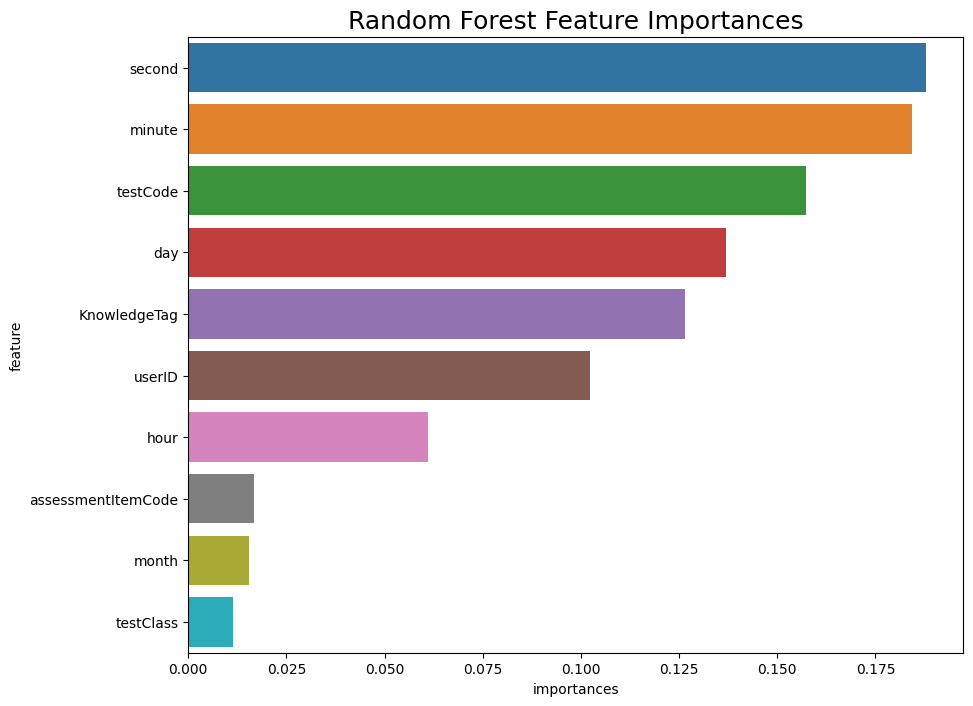

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.DataFrame()
importances['feature'] = lgb_model.feature_name_
importances['importances'] = lgb_model.feature_importances_
importances.sort_values('importances', ascending=False, inplace=True)
importances.reset_index(drop=True, inplace=True)

importances['importances'] = importances['importances'].apply(lambda x : x / sum(importances['importances']))

plt.figure(figsize=(10, 8))
sns.barplot(x='importances', y='feature', data=importances)
plt.title('Random Forest Feature Importances', fontsize=18)
plt.show()

## Regressor

In [58]:
def objective(trial):
    param = {
        # 'objective': 'binary', # 이진 분류
        # "tree_learner": trial.suggest_categorical("tree_learner", ["serial", "feature", "data", "voting"]),
        'boosting_type' : trial.suggest_categorical("boosting_type", ["dart", "gbdt"]),
        'verbose': -1,
        'metric': 'AUC',
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 0.001, 0.03),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        # 'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        'lambda_l1' : trial.suggest_loguniform('lambda_l1', 1e-8, 1e-1),
        'lambda_l2' : trial.suggest_loguniform('lambda_l2', 1e-8, 1e-1),
        'path_smooth' : trial.suggest_loguniform('path_smooth', 1e-8, 1e-3),
        'num_leaves' : trial.suggest_int('num_leaves', 30, 200),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 10, 100),
        'max_bin' : trial.suggest_int('max_bin', 100, 255),
        'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.5, 0.9),
        'bagging_fraction' : trial.suggest_uniform('bagging_fraction', 0.5, 0.9),
        # 'device' : 'gpu',
        # 'reg_alpha' : None,
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    loss = roc_auc_score(h_valid_y, lgb_model.predict(h_valid_X))
    return loss
        
study_lgb = optuna.create_study(direction='maximize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-11-17 09:35:31,903] A new study created in memory with name: no-name-735ead12-1155-41d1-8334-8769f1d64484
[I 2022-11-17 09:47:44,568] Trial 0 finished with value: 0.6651943554809072 and parameters: {'boosting_type': 'dart', 'max_depth': 3, 'learning_rate': 0.010593611172704924, 'n_estimators': 1512, 'min_child_samples': 6, 'lambda_l1': 3.827156455267053e-08, 'lambda_l2': 5.114798842531059e-07, 'path_smooth': 3.53574338739203e-08, 'num_leaves': 154, 'min_data_in_leaf': 48, 'max_bin': 111, 'feature_fraction': 0.5270035805384868, 'bagging_fraction': 0.5100774324596241}. Best is trial 0 with value: 0.6651943554809072.


[LightGBM] [Warning] lambda_l1 is set=7.224555022162843e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.224555022162843e-07
[LightGBM] [Warning] bagging_fraction is set=0.8089444905814129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8089444905814129
[LightGBM] [Warning] lambda_l2 is set=3.4366917146991675e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4366917146991675e-06
[LightGBM] [Warning] feature_fraction is set=0.6660342498207724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6660342498207724
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=25


[I 2022-11-17 09:47:49,844] Trial 1 finished with value: 0.6619417828211522 and parameters: {'boosting_type': 'gbdt', 'max_depth': 5, 'learning_rate': 0.003854857256610302, 'n_estimators': 1764, 'min_child_samples': 99, 'lambda_l1': 7.224555022162843e-07, 'lambda_l2': 3.4366917146991675e-06, 'path_smooth': 3.4976361716466646e-05, 'num_leaves': 31, 'min_data_in_leaf': 25, 'max_bin': 218, 'feature_fraction': 0.6660342498207724, 'bagging_fraction': 0.8089444905814129}. Best is trial 0 with value: 0.6651943554809072.


[LightGBM] [Warning] lambda_l1 is set=3.768992946902905e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.768992946902905e-05
[LightGBM] [Warning] bagging_fraction is set=0.5821262468839657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5821262468839657
[LightGBM] [Warning] lambda_l2 is set=0.0010524714642634024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010524714642634024
[LightGBM] [Warning] feature_fraction is set=0.8826552147959512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8826552147959512
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=73


[W 2022-11-17 09:58:42,643] Trial 2 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/opt/conda/envs/dkt/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_89911/3600500463.py", line 26, in objective
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
  File "/opt/conda/envs/dkt/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/opt/conda/envs/dkt/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/opt/conda/envs/dkt/lib/python3.8/site-packages/lightgbm/engine.py", line 292, in train
    booster.update(fobj=fobj)
  File "/opt/conda/envs/dkt/lib/python3.8/site-packages/lightgbm/basic.py", line 3021, in update
    _safe_call(_LIB.LGBM_Bo

KeyboardInterrupt: 

In [ ]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor


import warnings
import random
import os
seed=777
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.set_option('mode.chained_assignment',  None)
total = pd.read_csv("sequential_total.csv")
test_df = pd.read_csv("sequential_test.csv")

total = total.loc[total["answerCode"] != -1]
test_df = test_df.loc[test_df['answerCode'] == -1]

total = pd.concat([total.iloc[:, 0:9], total.iloc[:, 27:]], axis=1)
test_df = pd.concat([test_df.iloc[:, 0:9], test_df.iloc[:, 27:]], axis=1)

train_X = total.drop(['userID', 'answerCode', 'assessmentItemID', 'testId', 'Timestamp'], axis=1)
train_y = total[['userID', 'answerCode']]
test_X = test_df.drop(['userID', 'answerCode', 'assessmentItemID', 'testId', 'Timestamp'], axis=1)

h_train_X, h_valid_X, h_train_y, h_valid_y = train_test_split(train_X, train_y['answerCode'], test_size=0.3, stratify=train_y['answerCode'], random_state=seed)

cat_param = {'objective': 'CrossEntropy', 'depth': 8, 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.03349800020657192, 'n_estimators': 4674, 'l2_leaf_reg': 2.0980803041898785e-05, 'min_child_samples': 45, 'max_bin': 473, 'subsample': 0.8940174624296652}
cat = CatBoostClassifier(**cat_param, cat_features=[0, 1, 2, 3, ], task_type="GPU", random_state=seed,)
cat_model = cat.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)    
preds = cat_model.predict_proba(h_valid_X)
# pred_labels = np.rint(preds)
auc = roc_auc_score(h_valid_y, preds[:, 1])
auc

0.8688055159779466

In [17]:
submit = pd.read_csv("/opt/ml/input/data/sample_submission.csv")
preds = cat_model.predict_proba(test_X)
submit['prediction'] = preds[:, 1]
submit.to_csv("catclf_test.csv", index=False)

In [ ]:
model = lgb.LGBMRegressor(**trial_params)
lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)

In [ ]:
submit = pd.read_csv("/opt/ml/input/data/sample_submission.csv")
pred = lgb_model.predict(test_x)
submit['prediction'] = pred
submit

In [14]:
import torch
import pandas as pd
submit = pd.read_csv("../data/sample_submission.csv")
catreg = pd.read_csv("catregressor_ms_data.csv")
lightgcn = pd.read_csv("lightgcn_best.csv")
lstmattn = pd.read_csv("lstmattn_best.csv")
lgbm = pd.read_csv("lgbmregressor_ms_data.csv")
lastquery = pd.read_csv("submissionlastquery.csv")

lstmattn['prediction'] = torch.nn.Sigmoid()(torch.FloatTensor(lstmattn['prediction']))
ensemble = (lightgcn['prediction'] + lstmattn['prediction'] + lgbm['prediction'] + catreg['prediction']) / 4
submit['prediction'] = ensemble
submit.to_csv("lgbm_ms_data_lightgcn_best_lstmattn_best_catreg_ensemble4.csv", index=False)
ensemble

0      0.559759
1      0.819959
2      0.267818
3      0.775571
4      0.321204
         ...   
739    0.050060
740    0.626997
741    0.864996
742    0.749014
743    0.691075
Name: prediction, Length: 744, dtype: float64

In [17]:
import torch
import pandas as pd
submit = pd.read_csv("../data/sample_submission.csv")
lgbmreg = pd.read_csv("lgbmregressor_ms_data.csv")
catclf = pd.read_csv("catclf_ms_data.csv")
lightgcn = pd.read_csv("lightgcn_best.csv")
# lightgcn = pd.read_csv("output_(2).csv")
bert = pd.read_csv("output_(3).csv")
lstmattn = pd.read_csv("lstmattn_best.csv")

lstmattn['prediction'] = torch.nn.Sigmoid()(torch.FloatTensor(lstmattn['prediction']))
ensemble = (lightgcn['prediction'] + lgbmreg['prediction'] + catclf['prediction'] + lstmattn['prediction'] + bert['prediction']) / 5
submit['prediction'] = ensemble
submit.to_csv("lgbmreg_ms_data_bert_ms_lightgcn_lstmattn_best_catclf_ensemble.csv", index=False)
ensemble

0      0.531745
1      0.830938
2      0.308850
3      0.728801
4      0.267380
         ...   
739    0.039223
740    0.669865
741    0.795388
742    0.659552
743    0.726583
Name: prediction, Length: 744, dtype: float64